In [1]:
import numpy as np
from isens_vtrigU import isens_vtrigU 
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import proj3d
from scipy.constants import c
from scipy.io import savemat
import os

In [3]:
# load data
current_case = 'test04102023'
current_scenario = 'cf_y_angle_+20'
my_vtrig = isens_vtrigU(case=current_case)
calArr, recArr = my_vtrig.load_data(case=current_case, scenario=current_scenario)
proArr = my_vtrig.calibration(calArr,recArr,method=0)
proArr = np.fft.ifft(proArr,axis=2)
# test_signal = proArr[:,0,:]
mat_data = {}
mat_data['recs'] = proArr
savemat(f'./data/matlab_data/{current_scenario}_shorter_IFFT.mat',mat_data)

Freq Points: 150 
TxRxPairs Shape: (400, 2)
Nfft = 512
Number of Recorded Frames: 100

Current scenario: cf_y_angle_+20

calArr Shape: (10, 400, 150)
recArr Shape: (100, 400, 150)

recArr Channels: (frame, Tx*Rx, freqs)



In [ ]:
# Load Data
current_case = 'test04102023'
current_scenario = 'human_longer'
my_vtrig = isens_vtrigU(case=current_case)
calArr, recArr = my_vtrig.load_data(case=current_case, scenario=current_scenario)

# Parameter Setup
nframe = recArr.shape[0]
chosen_frame = 50
ntarget = 6             # number of 
bound = 2.5
Nfft = 512
y_offset_shift = 220 
x_offset_shift = -90
x_ratio = 20/30
y_ratio = 20/25
my_vtrig.dist_vec = my_vtrig.compute_dist_vec(Nfft=Nfft)

# Background Substraction
proArr = my_vtrig.calibration(calArr,recArr,method=0)

# Compute the Range Profile and Find the Target Range Bin (For one target)
range_profile = my_vtrig.range_pipeline(current_case,current_scenario, plot=True, Nfft=Nfft)[50,:]
range_profile[np.where(my_vtrig.dist_vec>bound)] = np.mean(range_profile)
range_peaks, _ = find_peaks(range_profile)
# Sort the peaks by their amplitudes in descending order and select the first 6 peaks
sorted_peak_indices = np.argsort(range_profile[range_peaks])[::-1][:ntarget]
top_range_peaks = range_peaks[sorted_peak_indices]
# Print the indices and angles of the top 6 peaks
print(f"Top {ntarget} range bin indices:", top_range_peaks)
print(f"Top {ntarget} range bins:", my_vtrig.dist_vec[top_range_peaks], '[m]')
plt.figure(figsize=(20,10))
plt.plot(my_vtrig.dist_vec,range_profile)
plt.scatter(my_vtrig.dist_vec[top_range_peaks],range_profile[top_range_peaks])
plt.show()
# target_range_bin = np.argmax(range_profile)
# range_bins = [target_range_bin-1, target_range_bin, target_range_bin+1]
# print(f'{my_vtrig.dist_vec[target_range_bin]} [m]')

# Generate the 3D map
tof = np.fft.ifft(proArr,n=Nfft,axis=2)                      # Do IFFT across frequency steps to get the range bins
tof[:,:,np.where(my_vtrig.dist_vec>bound)] = np.min(tof)       # Eliminate noise that is beyond the range

# tof = tof.reshape(nframe,20,20,-1)[chosen_frame,:,:,:]      # Reshape the range profile to Tx x Rx and extract a frame
tof = tof.reshape(nframe,20,20,-1)
tof = np.transpose(tof,axes=(1,2,3,0))
# tof = np.linalg.norm(tof,axis=0)
tof = np.fft.fft(tof,n=Nfft,axis=1)
tof = np.fft.fft(tof,n=Nfft,axis=0)
tof = my_vtrig.normalization(tof)
# tof[:,:,top_range_peaks] *= 10
tof = np.roll(tof,shift=y_offset_shift,axis=1)
tof = np.roll(tof,shift=x_offset_shift,axis=0)
# new shape: (AoD, AoA, Range) = (x, y, z)

# Example 3D matrix (replace this with your matrix)
matrix = np.abs(tof)

# Arrays to change the axis values (replace these with your arrays)
x_array = (my_vtrig.angle_vec-90)*x_ratio
y_array = (my_vtrig.angle_vec-90)*y_ratio
z_array = my_vtrig.dist_vec

# Channels to search for peaks (replace these with your desired channels)
channels_to_search = top_range_peaks
print(top_range_peaks)

# Create a masked copy of the matrix
masked_matrix = matrix.copy()
masked_matrix[:, :, [ch for ch in range(matrix.shape[2]) if ch not in channels_to_search]] = -np.inf

# Find the indices of the top 6 largest values
flat_indices = np.argsort(masked_matrix.flatten())[::-1][:ntarget]
indices_3d = np.unravel_index(flat_indices, matrix.shape)

# Extract x, y, and z coordinates of the top 6 peaks
x_peaks, y_peaks, z_peaks = indices_3d
doppler = np.fft.fft(np.real(tof[x_peaks, y_peaks, :, :]), axis=3)
d=(2*60+2.8)/500
doppler_freq = np.fft.fftfreq(500,d)
freq_low = 10
freq_high = 230
range_low = 100
range_high = 350
doppler = doppler[freq_low:freq_high,range_low:range_high]
plt.figure(figsize=(8,6))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Range [m]')
extent=[doppler_freq[freq_low],doppler_freq[freq_high],my_vtrig.dist_vec[range_low],my_vtrig.dist_vec[range_high]]
plt.imshow(np.abs(doppler).T,origin='lower',aspect='auto',extent=extent)
plt.colorbar()
plt.show()


print(matrix.shape)
print(x_peaks)
print(y_peaks)
print(z_peaks)
print(x_array[x_peaks])
print(y_array[y_peaks])
print(z_array[z_peaks])
# Create a 3D scatter plot for the original matrix
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

# Get x, y, z indices for the entire matrix
x, y, z = np.indices(matrix.shape)

# Add the entire matrix as blue points with changed axis values
# ax.scatter(x_array[x], y_array[y], z_array[z], c='b', alpha=0.3, label='Original matrix')

# Add the top 6 peaks to the plot with changed axis values
ax.scatter(x_array[x_peaks], y_array[y_peaks], z_array[z_peaks], c='r', marker='x', s=100, label=f'Top {ntarget} peaks')

# Set axis labels
ax.set_xlabel('X (AoD [deg])')
ax.set_ylabel('Y (AoA [deg])')
ax.set_zlabel('Z (Range [m])')

# Set plot title
plt.title(f"3D Matrix with Top {ntarget} Peaks (Changed Axis Values)")

# Set the axis limits to match the ranges of x_array, y_array, and z_array
ax.set_xlim(x_array.min(), x_array.max())
ax.set_ylim(y_array.min(), y_array.max())
ax.set_zlim(z_array.min(), z_array.max())

# Add legend
ax.legend()

# Show the plot
plt.show()

# Angle FFT

Freq Points: 150 
TxRxPairs Shape: (400, 2)
Nfft = 512
Number of Recorded Frames: 100

Current scenario: 2cf_xx_angle_+-20

calArr Shape: (10, 400, 150)
recArr Shape: (100, 400, 150)

recArr Channels: (frame, Tx*Rx, freqs)

Current scenario: 2cf_xx_angle_+-20

calArr Shape: (10, 400, 150)
recArr Shape: (100, 400, 150)

recArr Channels: (frame, Tx*Rx, freqs)



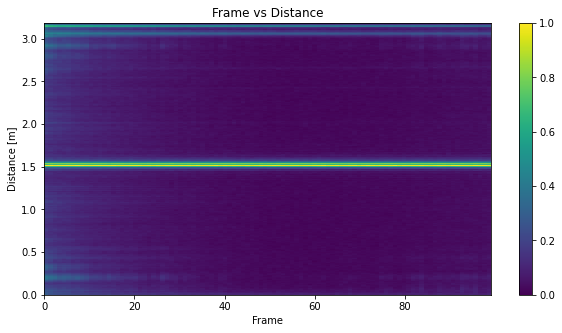

1.5143115895766588 [m]
-232
-4.0508806262230905


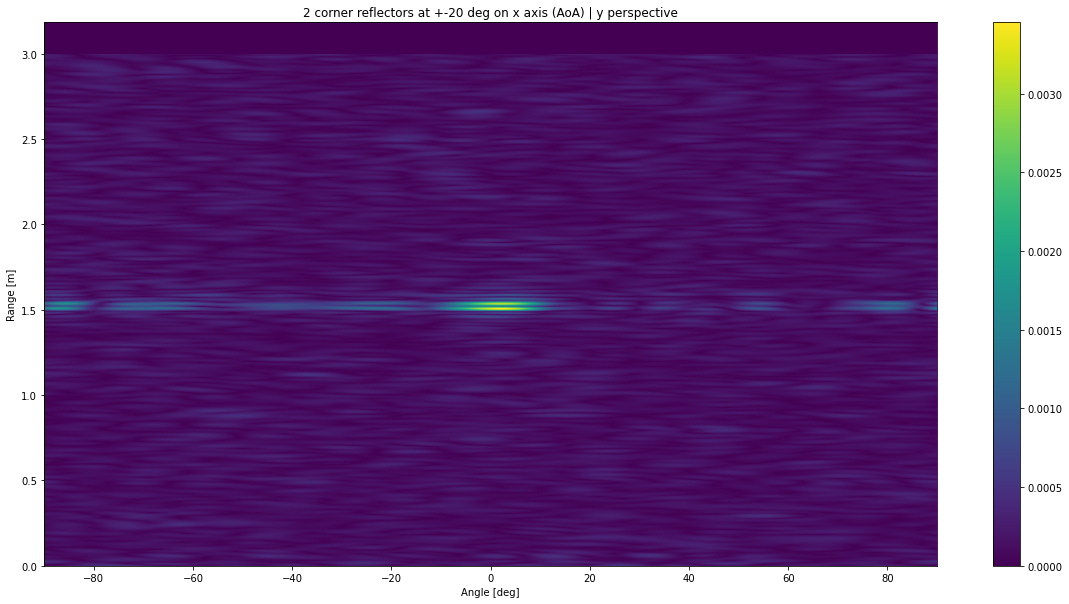

In [28]:
current_case = 'test01312023'
current_scenario = '2cf_xx_angle_+-20'
# current_scenario = 'human_longer'
my_vtrig = isens_vtrigU(case=current_case)
calArr, recArr = my_vtrig.load_data(case=current_case, scenario=current_scenario)
proArr = my_vtrig.calibration(calArr,recArr,method=0)
nframe = proArr.shape[0]

range_profile = my_vtrig.range_pipeline(current_case,current_scenario, plot=True)[50,:]
target_range_bin = np.argmax(range_profile)
range_bins = [target_range_bin-1, target_range_bin, target_range_bin+1]
print(f'{my_vtrig.dist_vec[target_range_bin]} [m]')


tof = np.fft.ifft(proArr,n=512,axis=2)
tof[:,:,np.where(my_vtrig.dist_vec>3)] = np.mean(tof)
tof = tof.reshape(nframe,20,20,-1)[50,10,:,:]
tof = np.squeeze(tof)
tof = np.fft.fft(tof,n=512,axis=0)
# print(tof[:,:,target_range_bin])
plt.figure(figsize=(20,10))
extent = [np.min(my_vtrig.angle_vec)-90,np.max(my_vtrig.angle_vec)-90,np.min(my_vtrig.dist_vec),np.max(my_vtrig.dist_vec)]
tof = tof.T
# y_offset_shift = np.argmin(tof[target_range_bin,:])-256 + 10
y_offset_shift = -232
print(y_offset_shift)
tof = np.roll(tof,shift=-y_offset_shift,axis=1)
plt.imshow(np.abs(tof),origin='lower',aspect='auto',extent=extent)
plt.colorbar()
plt.xlabel('Angle [deg]')
plt.ylabel('Range [m]')
plt.title('2 corner reflectors at +-20 deg on x axis (AoA) | y perspective')
print(my_vtrig.angle_vec[np.argmin(tof[target_range_bin,:])]-90)

Freq Points: 150 
TxRxPairs Shape: (400, 2)
Nfft = 512
Number of Recorded Frames: 100

Current scenario: 2cf_yy_angle_+-20

calArr Shape: (10, 400, 150)
recArr Shape: (100, 400, 150)

recArr Channels: (frame, Tx*Rx, freqs)

Current scenario: 2cf_yy_angle_+-20

calArr Shape: (10, 400, 150)
recArr Shape: (100, 400, 150)

recArr Channels: (frame, Tx*Rx, freqs)



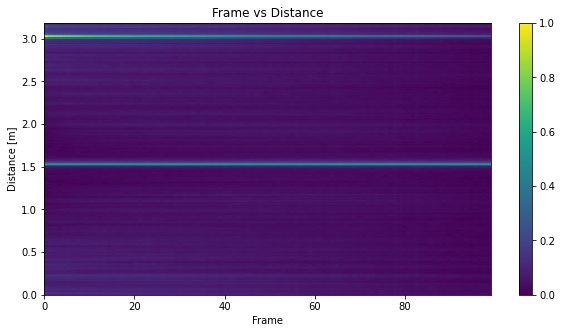

1.5330067943862473 [m]
80
4.814090019569467


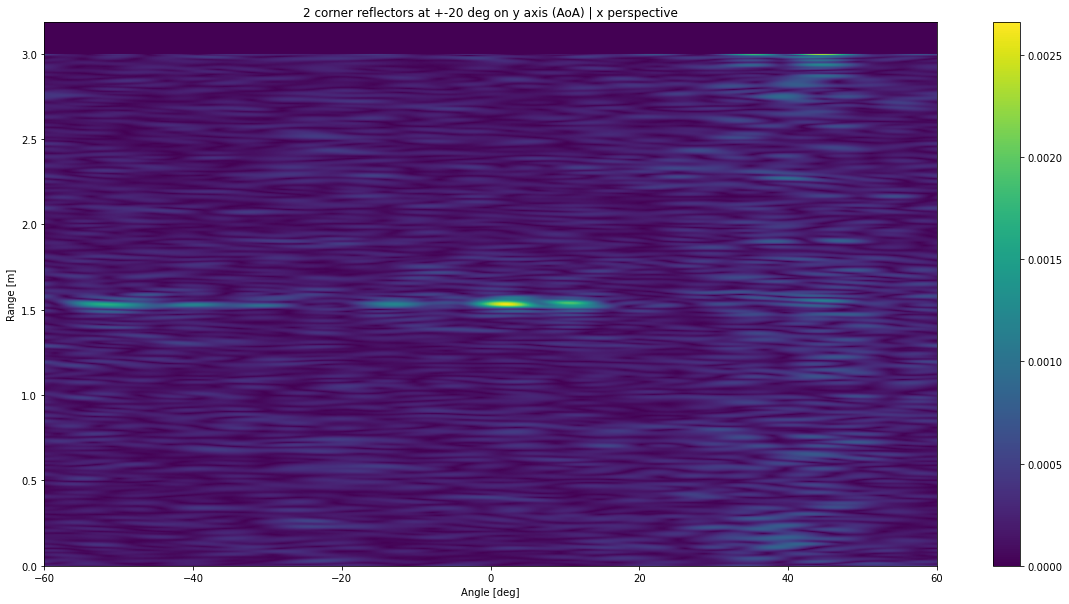

In [27]:
current_case = 'test01312023'
current_scenario = '2cf_yy_angle_+-20'
# current_case = 'test01242023'
# current_scenario = 'cf_x_angle_-20'
# current_scenario = 'human_longer'
my_vtrig = isens_vtrigU(case=current_case)
calArr, recArr = my_vtrig.load_data(case=current_case, scenario=current_scenario)
proArr = my_vtrig.calibration(calArr,recArr,method=0)
nframe = proArr.shape[0]

range_profile = my_vtrig.range_pipeline(current_case,current_scenario, plot=True)[50,:]
target_range_bin = np.argmax(range_profile)
range_bins = [target_range_bin-1, target_range_bin, target_range_bin+1]
print(f'{my_vtrig.dist_vec[target_range_bin]} [m]')


tof = np.fft.ifft(proArr,n=512,axis=2)
tof[:,:,np.where(my_vtrig.dist_vec>3)] = np.mean(tof)
tof = tof.reshape(nframe,20,20,-1)[50,:,10,:]
tof = np.squeeze(tof)
tof = np.fft.fft(tof,n=512,axis=0)
# print(tof[:,:,target_range_bin])
plt.figure(figsize=(20,10))

tof = tof.T
# x_offset_shift = np.argmin(tof[np.where(tof==np.max(tof))[0],:])-256 + 14
x_offset_shift = 80
print(x_offset_shift)
tof = np.roll(tof,shift=-x_offset_shift,axis=1)
ratio = 40/60
extent = [(np.min(my_vtrig.angle_vec)-90)*ratio,(np.max(my_vtrig.angle_vec)-90)*ratio,np.min(my_vtrig.dist_vec),np.max(my_vtrig.dist_vec)]
plt.imshow(np.abs(tof),origin='lower',aspect='auto',extent=extent)
plt.colorbar()
plt.xlabel('Angle [deg]')
plt.ylabel('Range [m]')
# print(my_vtrig.angle_vec[np.argmin(tof[np.where(tof==np.max(tof))[0],:])]-90)
# (range x angle)
# print(np.where(tof==np.max(tof)))
plt.title('2 corner reflectors at +-20 deg on y axis (AoA) | x perspective')
print((my_vtrig.angle_vec[np.argmax(tof[target_range_bin,:])]-90)*ratio)

Freq Points: 150 
TxRxPairs Shape: (400, 2)
Nfft = 512
Number of Recorded Frames: 100

Current scenario: human_1

calArr Shape: (10, 400, 150)
recArr Shape: (100, 400, 150)

recArr Channels: (frame, Tx*Rx, freqs)

Current scenario: human_1

calArr Shape: (10, 400, 150)
recArr Shape: (100, 400, 150)

recArr Channels: (frame, Tx*Rx, freqs)



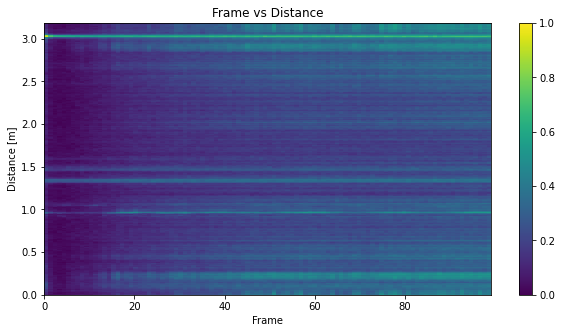

3.0286231791533176 [m]


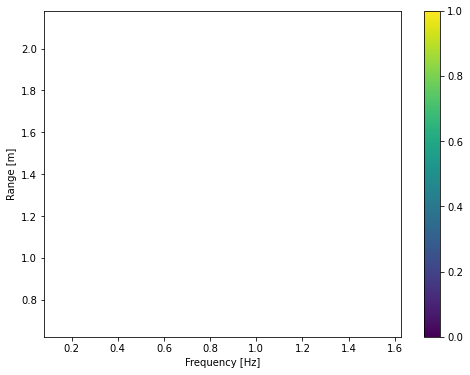

In [27]:
current_case = 'test04102023'
current_scenario = 'human_1'
my_vtrig = isens_vtrigU(case=current_case)
calArr, recArr = my_vtrig.load_data(case=current_case, scenario=current_scenario)
proArr = my_vtrig.calibration(calArr,recArr,method=0)

range_profile = my_vtrig.range_pipeline(current_case,current_scenario, plot=True)[50,:]
target_range_bin = np.argmax(range_profile)
range_bins = [target_range_bin-1, target_range_bin, target_range_bin+1]
print(f'{my_vtrig.dist_vec[target_range_bin]} [m]')

tof = np.fft.ifft(recArr,n=512,axis=2)
tof = tof/np.linalg.norm(tof,axis=1)[:,np.newaxis]
d=(2*60+2.8)/500
# d = 1/fs
doppler_freq = np.fft.fftfreq(500,d)
doppler = np.fft.fft(np.real(tof), axis=0)
# doppler = doppler[:,210,:]
doppler = np.linalg.norm(doppler,axis=1)
# doppler = doppler[5:-400,150:350]
# print(doppler_freq)
freq_low = 10
freq_high = -300
range_low = 100
range_high = 350
doppler = doppler[freq_low:freq_high,range_low:range_high]
plt.figure(figsize=(8,6))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Range [m]')
extent=[doppler_freq[freq_low],doppler_freq[freq_high],my_vtrig.dist_vec[range_low],my_vtrig.dist_vec[range_high]]
plt.imshow(np.abs(doppler).T,origin='lower',aspect='auto',extent=extent)
plt.colorbar()
plt.show()

In [22]:
import numpy as np
from scipy.signal import butter, filtfilt, hilbert, stft
from scipy.fft import fft

# load data
current_case = 'test04242023'
current_scenario = 'human_stretch_0.1'
my_vtrig = isens_vtrigU(case=current_case)
calArr, recArr = my_vtrig.load_data(case=current_case, scenario=current_scenario)
radar_data = my_vtrig.calibration(calArr,recArr,method=0)

# Parameters
num_frames = radar_data.shape[0]
total_duration =   num_frames*150/80e3 # total duration of the recording in seconds

# Estimate the frame rate
frame_rate = num_frames / total_duration

# Calculate the times array
times = np.arange(num_frames) / frame_rate

# Doppler-based method
def doppler_based_vital_sign_detection(radar_data, frame_rate):
    # Apply STFT on frames (time domain)
    frequencies, _, radar_stft = stft(radar_data, fs=frame_rate, axis=0)

    # Calculate the respiration rate and heart rate using the find_rate helper function
    respiration_rate, heart_rate = find_rate(frequencies, radar_stft)

    return respiration_rate, heart_rate

# Phase-based method
def phase_based_vital_sign_detection(radar_data, frame_rate):
    # Apply the Hilbert transform
    radar_data_real = np.real(np.fft.ifft(radar_data,axis=2))
    radar_hilbert = hilbert(radar_data_real, axis=0)

    # Calculate the phase
    radar_phase = np.angle(radar_hilbert)

    # Unwrap the phase
    radar_unwrapped_phase = np.unwrap(radar_phase, axis=0)

    # Calculate the phase difference (derivative)
    phase_diff = np.diff(radar_unwrapped_phase, axis=0)

    # Apply STFT on phase_diff (time domain)
    frequencies, _, phase_diff_stft = stft(phase_diff, fs=frame_rate, axis=0)

    # Calculate the respiration rate and heart rate using the find_rate helper function
    respiration_rate, heart_rate = find_rate(frequencies, phase_diff_stft)

    return respiration_rate, heart_rate

# Find rate helper function
def find_rate(frequencies, stft_data):
    # Sum the magnitudes across all antenna pairs
    stft_magnitude_sum = np.abs(stft_data).sum(axis=1)

    # Calculate the respiration rate
    resp_lowcut = 0.1
    resp_highcut = 0.5
    resp_mask = (frequencies >= resp_lowcut) & (frequencies <= resp_highcut)
    if resp_mask.any():
        resp_rate = frequencies[resp_mask][np.argmax(stft_magnitude_sum[resp_mask])]
    else:
        resp_rate = None

    # Calculate the heart rate
    heart_lowcut = 0.7
    heart_highcut = 2.5
    heart_mask = (frequencies >= heart_lowcut) & (frequencies <= heart_highcut)
    if heart_mask.any():
        heart_rate = frequencies[heart_mask][np.argmax(stft_magnitude_sum[heart_mask])]
    else:
        heart_rate = None

    return resp_rate, heart_rate


# Run the methods
resp_rate_doppler, heart_rate_doppler = doppler_based_vital_sign_detection(radar_data, frame_rate)
resp_rate_phase, heart_rate_phase = phase_based_vital_sign_detection(radar_data, frame_rate)
print(resp_rate_doppler, heart_rate_doppler)
print(resp_rate_phase, heart_rate_phase)

Freq Points: 150 
TxRxPairs Shape: (400, 2)
Nfft = 512
Number of Recorded Frames: 200

Current scenario: human_stretch_0.1

calArr Shape: (10, 400, 150)
recArr Shape: (200, 400, 150)

recArr Channels: (frame, Tx*Rx, freqs)



/opt/anaconda3/envs/vtrigU/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 200, using nperseg = 200
  .format(nperseg, input_length))
/opt/anaconda3/envs/vtrigU/lib/python3.7/site-packages/scipy/signal/spectral.py:1816: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '
/opt/anaconda3/envs/vtrigU/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 199, using nperseg = 199
  .format(nperseg, input_length))


None None
None None


Freq Points: 150 
TxRxPairs Shape: (400, 2)
Nfft = 512
Number of Recorded Frames: 100

Current scenario: cf_y_angle_0

calArr Shape: (10, 400, 150)
recArr Shape: (100, 400, 150)

recArr Channels: (frame, Tx*Rx, freqs)

Current scenario: cf_y_angle_0

calArr Shape: (10, 400, 150)
recArr Shape: (100, 400, 150)

recArr Channels: (frame, Tx*Rx, freqs)

0.19941551796894272 [m]


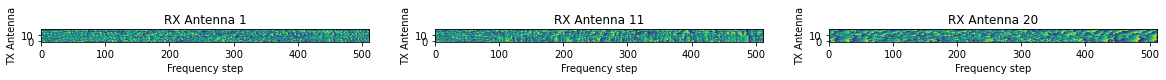

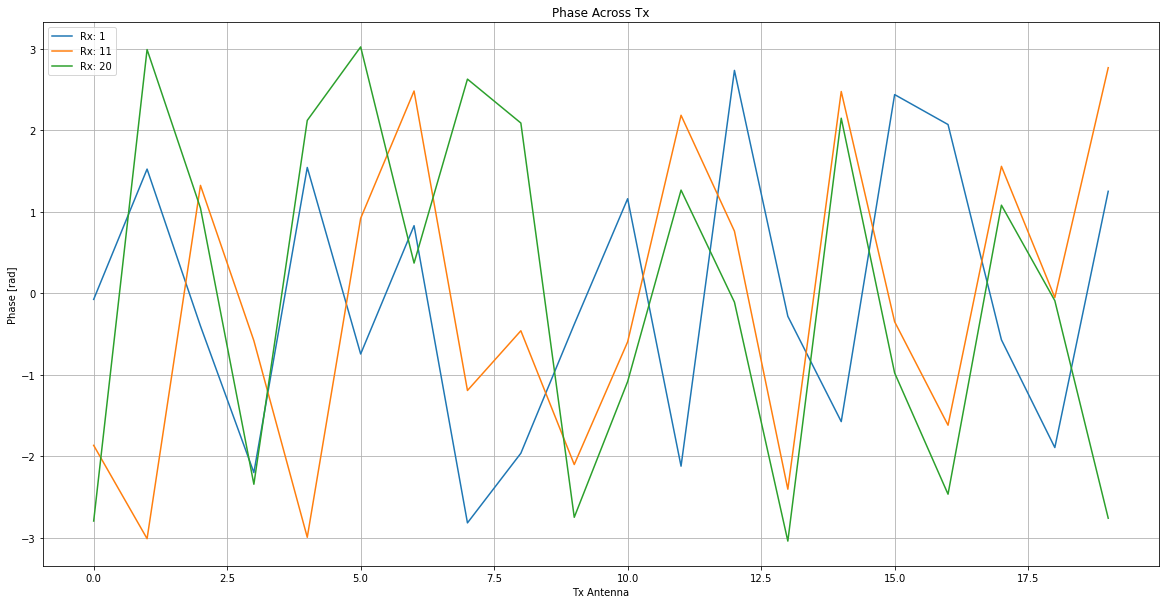

In [9]:
current_case = 'test04102023'
current_scenario = 'cf_y_angle_0'
my_vtrig = isens_vtrigU(case=current_case)
calArr, recArr = my_vtrig.load_data(case=current_case, scenario=current_scenario)
proArr = my_vtrig.calibration(calArr,recArr,method=0)
range_profile = my_vtrig.range_pipeline(current_case,current_scenario, plot=False)[50,:]
range_bin = np.argmax(range_profile)
print(f'{my_vtrig.dist_vec[range_bin]} [m]')

def phase(iq_data):
    phase_data = np.angle(iq_data)
    unwrapped_phase_data = np.unwrap(phase_data, axis=2) # Unwrap along the frequency steps axis
    unwrapped_phase_data = phase_data
    return unwrapped_phase_data   

test_signal = np.fft.ifft(proArr[50],n=my_vtrig.Nfft,axis=1).reshape(20,20,-1)
test_signal_phase = phase(test_signal)

rx_antennas = [0, 10, 19]
plt.figure(figsize=(20,10))
for i, rx in enumerate(rx_antennas):
    plt.subplot(1, 3, i + 1)
    plt.imshow(test_signal_phase[:, rx, :],origin='lower')
    plt.xlabel("Frequency step")
    plt.ylabel("TX Antenna")
    plt.title(f"RX Antenna {rx+1}")
    # plt.colorbar()
plt.show()

plt.figure(figsize=(20,10))
for i, rx in enumerate(rx_antennas):
    plt.plot(test_signal_phase[:, rx, range_bin],label=f'Rx: {rx+1}')
plt.xlabel("Tx Antenna")
plt.ylabel("Phase [rad]")
plt.title(f"Phase Across Tx")
plt.legend()
plt.grid()
plt.show()

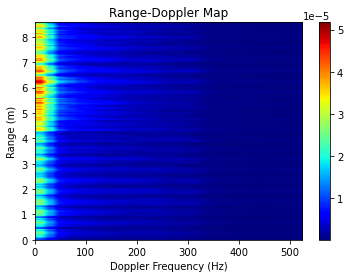

In [10]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

# Load your dataset (assuming a NumPy array with dimensions 100x400x150)
data = proArr

# Constants and parameters
n_frames, n_antenna_pairs, n_freq_points = 100, 400, 150
bandwidth = 69 - 62
f_start = 62e9
f_stop = 69e9
freqs = my_vtrig.freq

# Calculate the range resolution
c = 3e8  # speed of light
range_resolution = c / (2 * bandwidth * 1e9)

# Compute the range profile
range_profile = np.fft.ifft(data, n=my_vtrig.Nfft, axis=2)

# STFT parameters
nperseg = 50
noverlap = 25

# Calculate the number of Doppler frequency bins
n_doppler_bins = nperseg // 2 + 1

# Range-Doppler Map (RDM) initialization
rdm = np.zeros((n_antenna_pairs, n_doppler_bins))

# Processing loop
for i in range(n_antenna_pairs):
    # Extract the antenna pair data
    pair_data = range_profile[:, i, :]
    
    # Bandpass filter design (adjust the frequency range as needed)
    low_freq, high_freq = 0.1, 4  # Hz, typical range for respiration and heartbeat rates
    nyquist = 0.5 * n_frames
    low, high = low_freq / nyquist, high_freq / nyquist
    b, a = signal.butter(4, [low, high], btype='band')
    
    # Apply the bandpass filter to the data
    filtered_data = signal.lfilter(b, a, np.abs(pair_data), axis=0)
    
    # Perform Short-Time Fourier Transform (STFT)
    _, doppler_freqs, Zxx = signal.stft(filtered_data, nperseg=nperseg, noverlap=noverlap)
    
    # Calculate the magnitude and update the Range-Doppler Map
    rdm[i, :] = np.mean(np.abs(Zxx), axis=(0, 2))

# Plot the Range-Doppler Map
plt.imshow(rdm, cmap='jet', aspect='auto', origin='lower',
           extent=[doppler_freqs[0], doppler_freqs[-1], 0, n_antenna_pairs * range_resolution])
plt.xlabel('Doppler Frequency (Hz)')
plt.ylabel('Range (m)')
plt.title('Range-Doppler Map')
plt.colorbar()
plt.show()

Freq Points: 150 
TxRxPairs Shape: (400, 2)
Nfft = 512
Number of Recorded Frames: 100

Current scenario: cf_y_angle_0

calArr Shape: (10, 400, 150)
recArr Shape: (100, 400, 150)

recArr Channels: (frame, Tx*Rx, freqs)

Current scenario: cf_y_angle_0

calArr Shape: (10, 400, 150)
recArr Shape: (100, 400, 150)

recArr Channels: (frame, Tx*Rx, freqs)



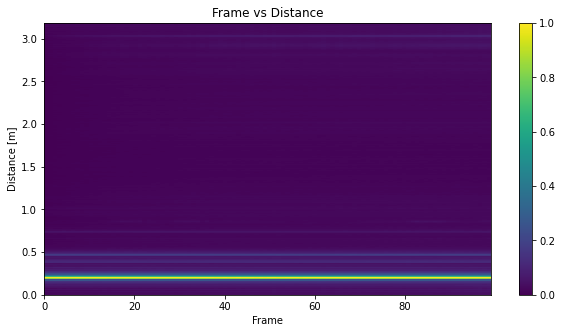

0.19941551796894272 [m]
(20, 20, 512)


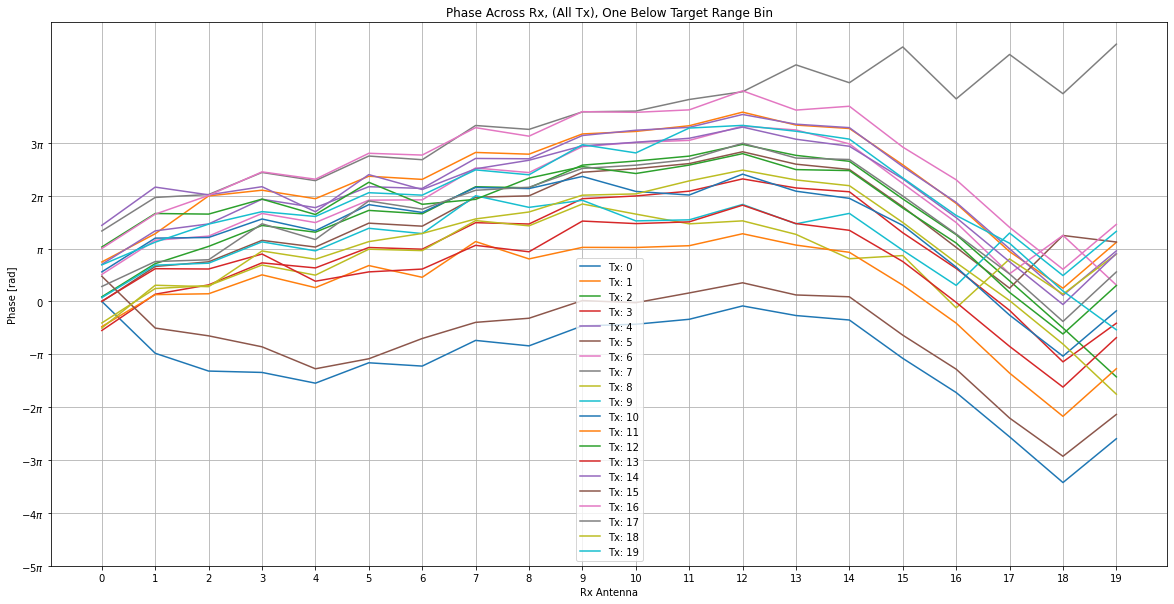

(20, 20, 512)


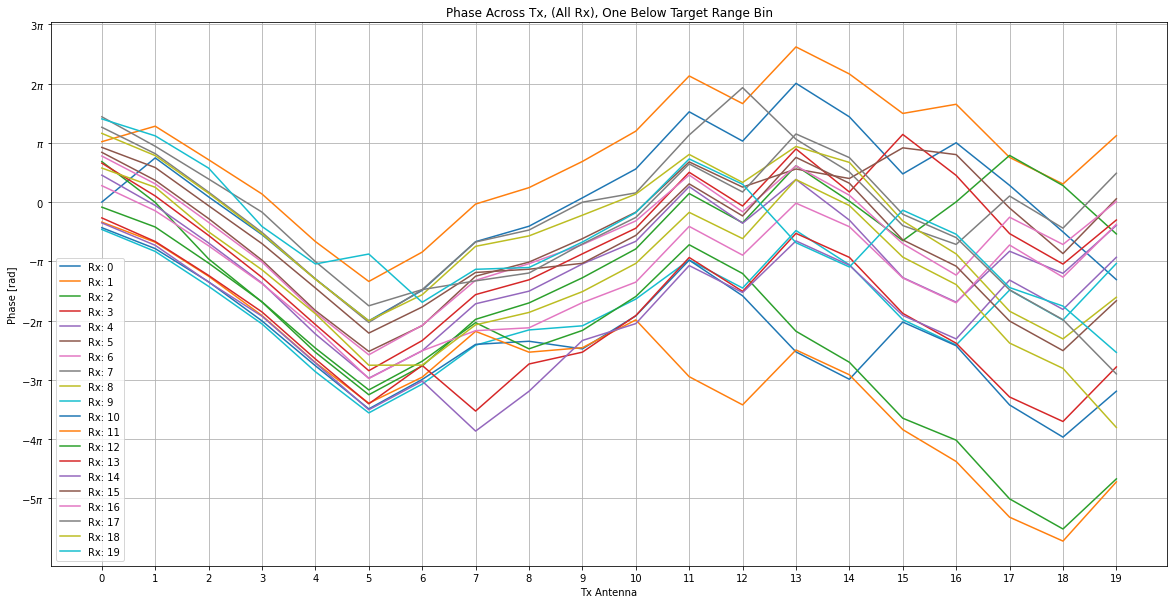

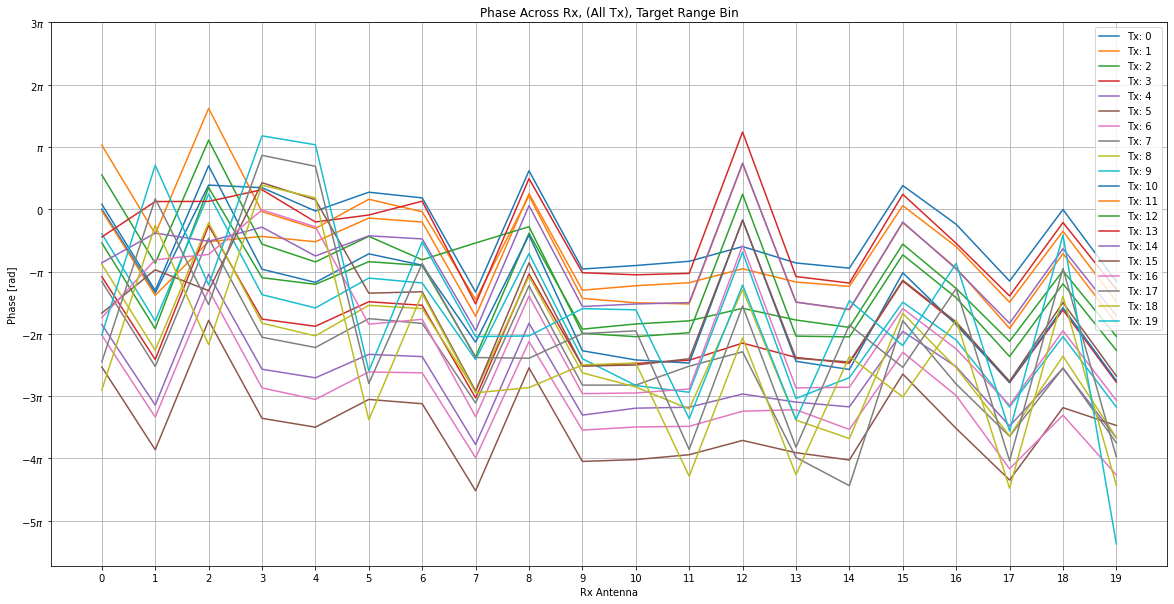

(20, 20, 512)


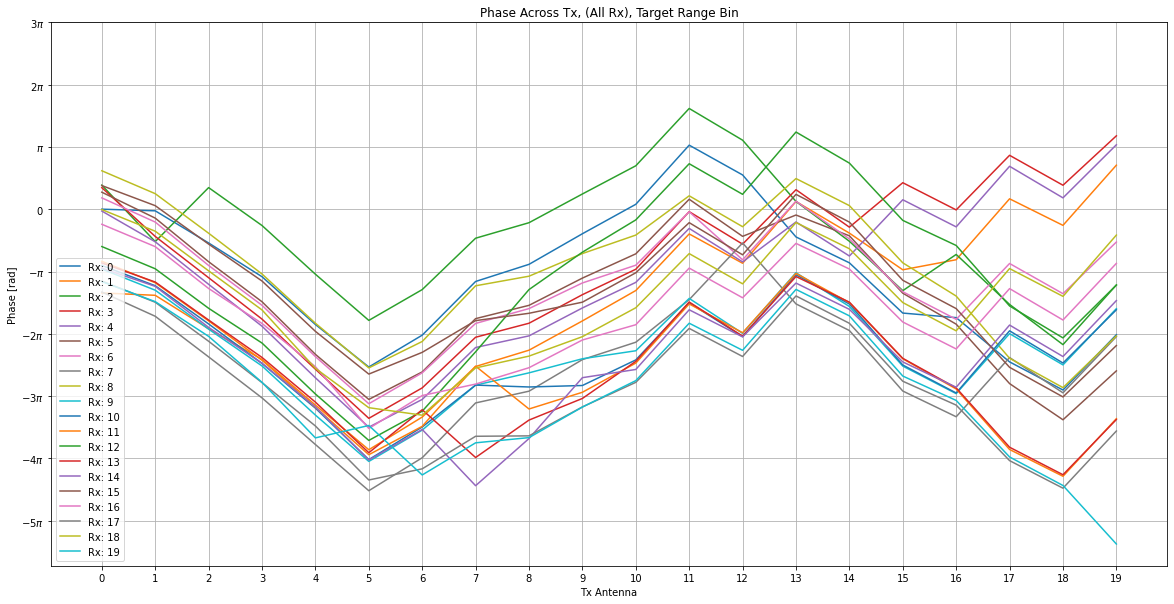

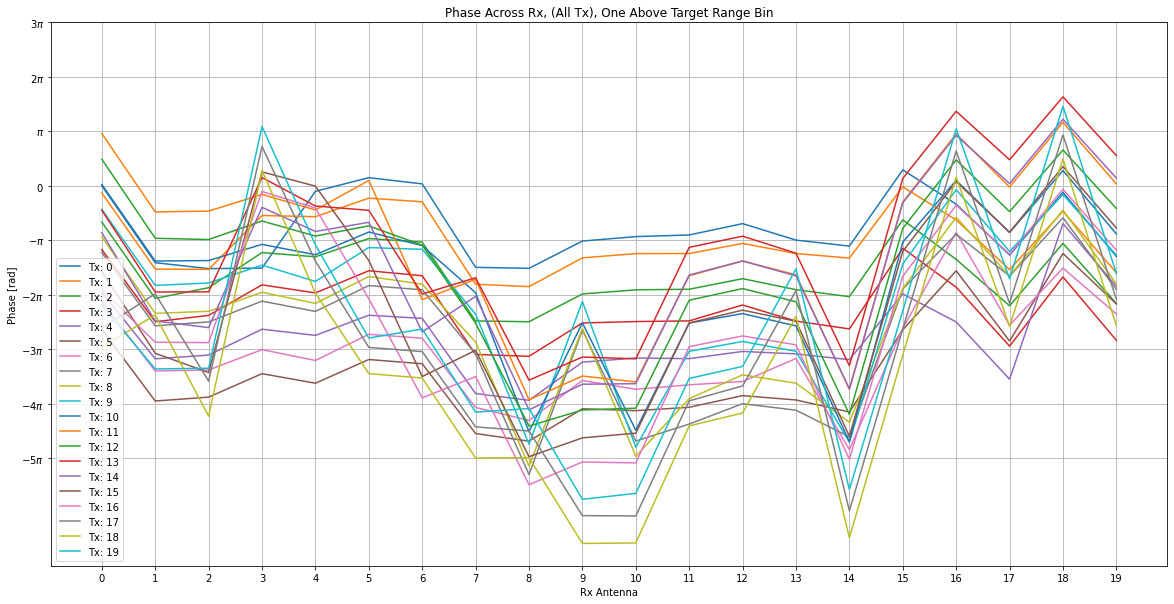

(20, 20, 512)


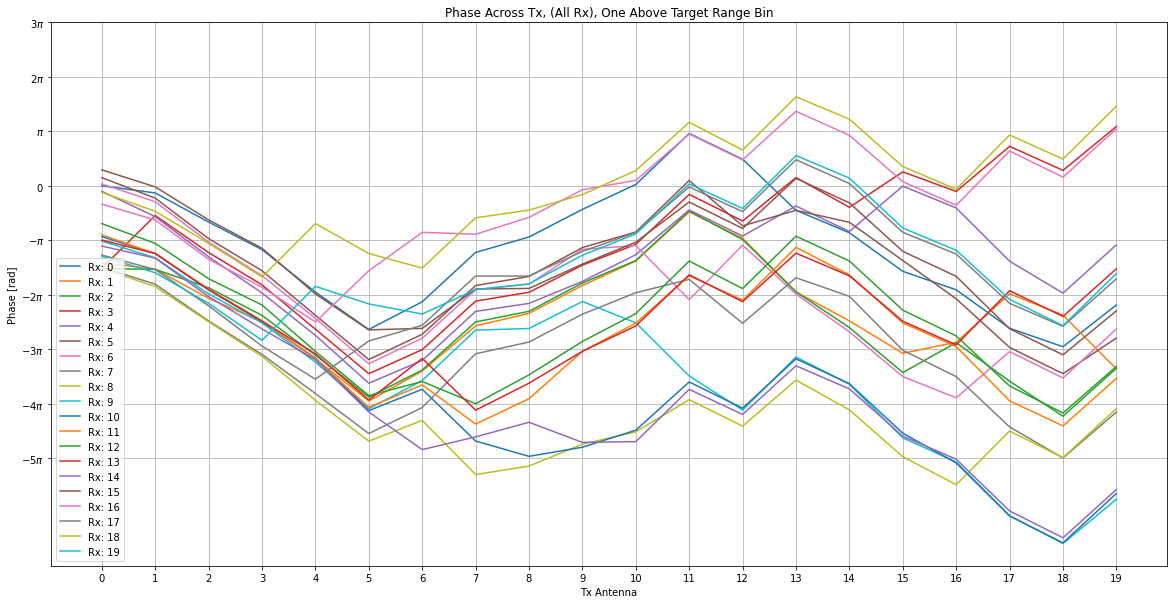

In [126]:
current_case = 'test04102023'
current_scenario = 'cf_y_angle_0'
# current_scenario = 'human_2'
my_vtrig = isens_vtrigU(case=current_case)
calArr, recArr = my_vtrig.load_data(case=current_case, scenario=current_scenario)
proArr = my_vtrig.calibration(calArr,recArr,method=0)
range_profile = my_vtrig.range_pipeline(current_case,current_scenario, plot=True)[50,:]
target_range_bin = np.argmax(range_profile)
range_bins = [target_range_bin-1, target_range_bin, target_range_bin+1]
print(f'{my_vtrig.dist_vec[target_range_bin]} [m]')

def phase(iq_data, ant='tx'):
    phase_data = np.angle(iq_data) - np.angle(iq_data[0,0,:])
    print(phase_data.shape)
    if ant=='tx':
        unwrapped_phase_data = np.unwrap(phase_data,axis=0,period=2*np.pi)
    else:
        unwrapped_phase_data = np.unwrap(phase_data,axis=1,period=2*np.pi)
    # unwrapped_phase_data = phase_data
    return unwrapped_phase_data   

test_signal = np.fft.ifft(proArr[50],n=my_vtrig.Nfft,axis=1).reshape(20,20,-1)

test_signal_phase = phase(test_signal, ant='rx')

for range_bin in range_bins:
    if range_bin == target_range_bin+1:
        title_postfix = 'One Above Target Range Bin'
    elif range_bin == target_range_bin-1:
        title_postfix = 'One Below Target Range Bin'
    else:
        title_postfix = 'Target Range Bin'

    # tx_antennas = [0, 5, 10, 15, 19]

    # plt.figure(figsize=(20,10))
    # for i, tx in enumerate(tx_antennas):
    #     plt.plot(test_signal_phase[tx, :, range_bin],label=f'Tx: {tx}')
    # plt.xlabel("Rx Antenna")
    # plt.ylabel("Phase [rad]")
    # plt.title(f"Phase Across Rx, (5 Tx), {title_postfix}")
    # plt.xticks(np.arange(0,20,1))
    # # plt.yticks(np.arange(-2*np.pi, 3*np.pi+np.pi/2, step=(np.pi)), [r"$-2\pi$",r'$-\pi$',r'$0$',r'$\pi$',r'$2\pi$',r'$3\pi$'])
    # plt.yticks(np.arange(-5*np.pi, 3*np.pi+np.pi/2, step=(np.pi)), [r"$-5\pi$",r'$-4\pi$',r'$-3\pi$',r'$-2\pi$',r'$-\pi$',r'$0$',r'$\pi$',r'$2\pi$',r'$3\pi$'])
    # plt.legend()
    # plt.grid()
    # plt.show()

    tx_antennas = np.arange(0,20,1)

    plt.figure(figsize=(20,10))
    for i, tx in enumerate(tx_antennas):
        plt.plot(test_signal_phase[tx, :, range_bin],label=f'Tx: {tx}')
    plt.xlabel("Rx Antenna")
    plt.ylabel("Phase [rad]")
    plt.title(f"Phase Across Rx, (All Tx), {title_postfix}")
    plt.xticks(np.arange(0,20,1))
    # plt.yticks(np.arange(-2*np.pi, 3*np.pi+np.pi/2, step=(np.pi)), [r"$-2\pi$",r'$-\pi$',r'$0$',r'$\pi$',r'$2\pi$',r'$3\pi$'])
    plt.yticks(np.arange(-5*np.pi, 3*np.pi+np.pi/2, step=(np.pi)), [r"$-5\pi$",r'$-4\pi$',r'$-3\pi$',r'$-2\pi$',r'$-\pi$',r'$0$',r'$\pi$',r'$2\pi$',r'$3\pi$'])
    plt.legend()
    plt.grid()
    plt.show()



    test_signal_phase = phase(test_signal)

    # rx_antennas = [0, 5, 10, 15, 19]

    # plt.figure(figsize=(20,10))
    # for i, rx in enumerate(rx_antennas):
    #     plt.plot(test_signal_phase[:, rx, range_bin],label=f'Rx: {rx}')
    # plt.xlabel("Tx Antenna")
    # plt.ylabel("Phase [rad]")
    # plt.title(f"Phase Across Tx (5 Rx), {title_postfix}")
    # plt.xticks(np.arange(0,20,1))
    # plt.yticks(np.arange(-5*np.pi, 3*np.pi+np.pi/2, step=(np.pi)), [r"$-5\pi$",r'$-4\pi$',r'$-3\pi$',r'$-2\pi$',r'$-\pi$',r'$0$',r'$\pi$',r'$2\pi$',r'$3\pi$'])
    # plt.legend()
    # plt.grid()
    # plt.show()

    rx_antennas = np.arange(0,20,1)

    plt.figure(figsize=(20,10))
    for i, rx in enumerate(rx_antennas):
        plt.plot(test_signal_phase[:, rx, range_bin],label=f'Rx: {rx}')
    plt.xlabel("Tx Antenna")
    plt.ylabel("Phase [rad]")
    plt.title(f"Phase Across Tx, (All Rx), {title_postfix}")
    plt.xticks(np.arange(0,20,1))
    plt.yticks(np.arange(-5*np.pi, 3*np.pi+np.pi/2, step=(np.pi)), [r"$-5\pi$",r'$-4\pi$',r'$-3\pi$',r'$-2\pi$',r'$-\pi$',r'$0$',r'$\pi$',r'$2\pi$',r'$3\pi$'])
    plt.legend()
    plt.grid()
    plt.show()



Current scenario: cf_y_angle_0

calArr Shape: (10, 400, 150)
recArr Shape: (100, 400, 150)

recArr Channels: (frame, Tx*Rx, freqs)



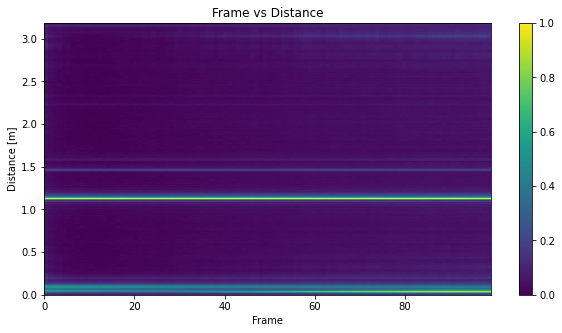

In [45]:
current_case = 'test01242023'
current_scenario = 'cf_y_angle_0'
range_profile = my_vtrig.range_pipeline(current_case,current_scenario, plot=True)[50,:]

1.1279440235118323 [m]


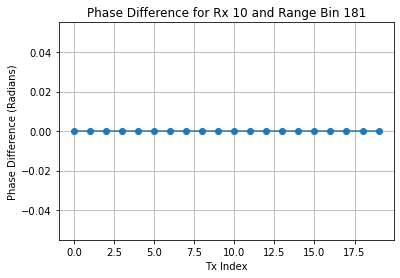

In [51]:
test_signal = np.abs(np.fft.ifft(proArr[50], n=512, axis=1))

# Select the specific range bin (e.g., 100)
range_bin = np.argmax(range_profile)
print(f'{my_vtrig.dist_vec[range_bin]} [m]')

tx_loc = my_vtrig.ants_locations[:20,:]
rx_loc = my_vtrig.ants_locations[20:40,:]

rx_idx = 10  # Define the specific Rx index
range_bin_idx = np.argmax(range_profile)  # Define the specific range bin index

# Calculate the distance between Tx and Rx antennas
distances = np.linalg.norm(tx_loc - rx_loc[rx_idx], axis=1)

# Calculate the path difference for each Tx antenna
path_difference = distances - distances[0]

# Compute the expected range data based on the path difference
c = 3e8  # Speed of light in m/s
bin_duration = my_vtrig.time_vec[1]-my_vtrig.time_vec[0]  # Time duration of each range bin
range_difference = c * bin_duration * path_difference / 2

# Calculate the phase difference between the measured and expected range data
phase_difference = np.zeros(20)
for tx_idx in range(20):
    antenna_pair_idx = tx_idx * 20 + rx_idx
    measured_range_data = test_signal[antenna_pair_idx, range_bin_idx]
    expected_range_data = measured_range_data + range_difference[tx_idx]
    phase_difference[tx_idx] = np.angle(expected_range_data) - np.angle(measured_range_data)
phase_difference = np.unwrap(phase_difference)

# Visualize the phase difference
plt.plot(range(20), phase_difference, 'o-')
plt.xlabel('Tx Index')
plt.ylabel('Phase Difference (Radians)')
plt.title(f'Phase Difference for Rx {rx_idx} and Range Bin {range_bin_idx}')
plt.grid()
plt.show()

In [4]:
# ground trugh of range profile
range_profile_ifft = my_vtrig.range_pipeline(case=current_case,scenario=current_scenario,cal_method=0)

Current scenario: cf_x_angle_0

calArr Shape: (10, 400, 150)
recArr Shape: (100, 400, 150)

recArr Channels: (frame, Tx*Rx, freqs)



<Figure size 432x288 with 0 Axes>

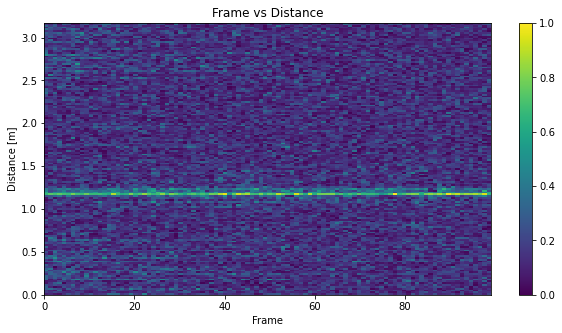

In [5]:
test_signal = proArr[:,0,:]
range_profile = np.abs(np.fft.ifft(test_signal,axis=1)).T
Ts = 1/len(my_vtrig.freq)/(my_vtrig.freq[1]-my_vtrig.freq[0]+1e-16) # Avoid nan checks
time_vec = np.linspace(0,Ts*(len(my_vtrig.freq)-1),num=len(my_vtrig.freq))
dist_vec = time_vec*(c/2)
plt.figure()
extent = [0, 99, 0, np.max(dist_vec)]
plt.figure(figsize=(10,5))
plt.imshow(my_vtrig.normalization(range_profile), origin='lower', interpolation='nearest', aspect='auto', extent=extent)
plt.colorbar()
plt.title('Frame vs Distance')
plt.xlabel('Frame')
plt.ylabel('Distance [m]')
plt.show(block=True)


<Figure size 432x288 with 0 Axes>

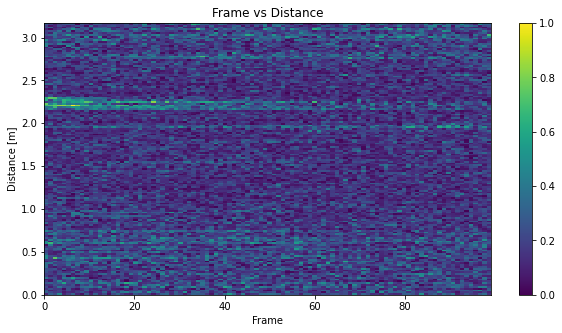

In [6]:
df = my_vtrig.freq[1] - my_vtrig.freq[0]
Ts = 1/len(my_vtrig.freq)/(my_vtrig.freq[1]-my_vtrig.freq[0]+1e-16) # Avoid nan checks
time_vec = np.linspace(0,Ts*(len(my_vtrig.freq)-1),num=len(my_vtrig.freq))
dist_vec = time_vec*(c/2)
freq_shift = np.arange(0,len(my_vtrig.freq))
freq_shift =  my_vtrig.freq[0]+(df*freq_shift)
tof_steering_vector = np.exp((2j*np.pi*freq_shift.reshape((1,-1)))*(time_vec.reshape((-1,1))),dtype='complex')

test_signal = proArr[:,0,:]
range_profile_steering = np.zeros([test_signal.shape[0],tof_steering_vector.shape[0],tof_steering_vector.shape[1]],dtype='complex')
for i in range(100):
    range_profile_steering[i,:,:] = test_signal[i,:] * tof_steering_vector
# range_profile_steering = np.abs(np.sum(range_profile_steering, axis=1)).T
range_profile_steering = np.linalg.norm(range_profile_steering, axis=1).T


plt.figure()
extent = [0, 99, 0, np.max(dist_vec)]
plt.figure(figsize=(10,5))
plt.imshow(my_vtrig.normalization(range_profile_steering), origin='lower',interpolation='nearest', aspect='auto', extent=extent)
plt.colorbar()
plt.title('Frame vs Distance')
plt.xlabel('Frame')
plt.ylabel('Distance [m]')
plt.show(block=True)


In [7]:
# load data
current_case = 'test01242023'
current_scenario = 'cf_x_angle_0'
my_vtrig = isens_vtrigU(case=current_case)
calArr, recArr = my_vtrig.load_data(case=current_case, scenario=current_scenario)
proArr = my_vtrig.calibration(calArr,recArr,method=0)

Freq Points: 150 
TxRxPairs Shape: (400, 2)
Nfft = 512
Number of Recorded Frames: 100

Current scenario: cf_x_angle_0

calArr Shape: (10, 400, 150)
recArr Shape: (100, 400, 150)

recArr Channels: (frame, Tx*Rx, freqs)



(1+0j)
[[1.6493275047659374e-23, array([ 5.20237882e-02+4.11461102e-02j,  1.14766557e-03+2.92229005e-03j,
       -6.44925280e-03-2.48259513e-03j,  9.15154512e-03-2.55956852e-02j,
       -1.53008228e-02+1.34095058e-02j, -4.57560154e-02-7.40118709e-03j,
       -8.97849348e-03-5.05610241e-02j, -1.32407980e-02+1.65576635e-02j,
       -6.19190818e-03-6.71924567e-03j,  6.93982937e-03-2.07301723e-02j,
       -6.96768704e-03-1.16743972e-02j, -2.00528063e-02-6.38769409e-03j,
       -7.57044997e-04+5.78852234e-03j, -5.14977910e-02-1.29927744e-02j,
       -3.18128070e-02-2.19130506e-02j,  1.93916574e-02-1.03791191e-02j,
       -1.38946771e-02-1.80013295e-02j,  1.76739619e-02-6.22460168e-03j,
       -8.01363890e-03-1.99720054e-03j,  1.31097664e-03+3.28358585e-02j,
        2.26234124e-02+3.15635279e-02j,  1.03789574e-02-1.37733682e-02j,
        2.49751875e-02-7.87684519e-03j,  3.72945082e-02+5.29161840e-02j,
        4.86521515e-02-4.14386959e-02j,  1.19173590e-02-3.23844307e-02j,
       -2.24004129

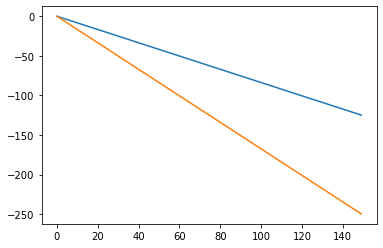

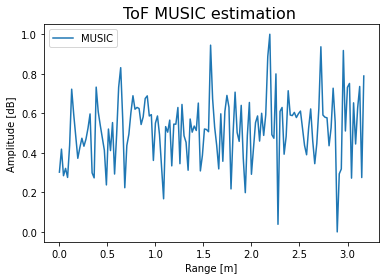

In [36]:
from pyargus.directionEstimation import *
def music_sim_signal(self, taus = [1.0,1.5]):
        # Number of antenna elements
        M = 150
        # number of samples
        N = 150
        # Interelement spacing is half-wavelength
        d= 0.5
        a_list = []
        for tau in taus:
            a_list.append(np.exp(freq_shift*1j*2*np.pi*tau))
        # Generate multichannel test signal 
        soi = np.random.normal(0,1,N)  # Signal of Interest
        soi_matrix = np.zeros(np.size(np.outer( soi, a_list[0])))
        for a in a_list:
            soi_matrix  += np.outer( soi, a)
        soi_matrix = soi_matrix.T
        # Generate multichannel uncorrelated noise
        noise = np.random.normal(0,np.sqrt(10**-1),(M,N))
        # Create received signal array
        rec_signal = soi_matrix + noise
        return rec_signal 

def compute_tof_scanning_vector(freq, time_vec):
    # Compute the scanning vector
    df = freq[1] - freq[0]
    freq_shift = np.arange(0,len(freq))
    freq_shift =  df*freq_shift
    scanning_vectors = np.zeros((len(freq),len(time_vec)),dtype='complex')
    for i in range(len(time_vec)):
        scanning_vectors[:,i] = np.exp(-1j*2*np.pi*freq_shift*time_vec[i])
    plt.figure()
    plt.plot(np.unwrap(np.angle(scanning_vectors[:,20])))
    plt.plot(np.unwrap(np.angle(scanning_vectors[:,40])))
    print((scanning_vectors[0,40]))
    # scanning_vectors = np.real(scanning_vectors)
    # scanning_vectors = np.exp(1j*2*np.pi*time_vec).reshape(-1,1)
    return scanning_vectors


def compute_tof_music(test_signal, scanning_vectors, signal_dimension=3, plot=False):
    test_signal = test_signal.reshape(-1,1)

    # Compute the correlation matrix
    R = np.dot(test_signal, test_signal.conj().T)

    # Implement MUSIC for ToF
    tof = np.zeros(np.size(scanning_vectors, 1))
    M = np.size(R, 0)

    # --- Calculation ---
    # Determine eigenvectors and eigenvalues
    sigmai, vi = lin.eig(R)
    # Sorting    
    eig_array = []
    for i in range(M):
        eig_array.append([np.abs(sigmai[i]),vi[:,i]])
    eig_array = sorted(eig_array, key=lambda eig_array: eig_array[0], reverse=False)
    print(eig_array)

    # Generate noise subspace matrix
    noise_dimension = M - signal_dimension    
    E = np.zeros((M,noise_dimension),dtype=complex)
    for i in range(noise_dimension):     
        E[:,i] = eig_array[i][1]     
        
    E = np.matrix(E)    
    theta_index=0
    for i in range(np.size(scanning_vectors, 1)):             
        S_theta_ = scanning_vectors[:, i]
        S_theta_  = np.matrix(S_theta_).getT() 
        tof[theta_index]=  1/np.abs(S_theta_.getH()*(E*E.getH())*S_theta_)
        theta_index += 1

    log_scale_min = -50

    tof = np.divide(np.abs(tof),np.max(np.abs(tof))) # normalization 
    tof = 10*np.log10(tof)                
    time_index = 0        
    for t in time_vec:                    
        if tof[time_index] < log_scale_min:
            tof[time_index] = log_scale_min
        time_index += 1   
    tof = my_vtrig.normalization(np.abs(tof))
    if plot:
        plt.figure()
        axes = plt.axes()
        axes.plot(dist_vec,tof)    
        axes.set_title('ToF MUSIC estimation ',fontsize = 16)
        axes.set_xlabel('Range [m]')
        axes.set_ylabel('Amplitude [dB]')   
        axes.legend(["MUSIC"])
    # print(tof)
    return tof

# Extract the data of the first TxRx pair in the first frame
test_signal = proArr[0,0,:]
time_vec = np.linspace(0,Ts*(len(my_vtrig.freq)-1),num=len(my_vtrig.freq),dtype='complex')
scanning_vectors = compute_tof_scanning_vector(my_vtrig.freq,time_vec)
test_tof = compute_tof_music(test_signal=test_signal, scanning_vectors=scanning_vectors, signal_dimension=10,plot=True)
print(dist_vec[np.argmax(test_tof)])

Current scenario: cf_x_angle_0

calArr Shape: (10, 400, 150)
recArr Shape: (100, 400, 150)

recArr Channels: (frame, Tx*Rx, freqs)



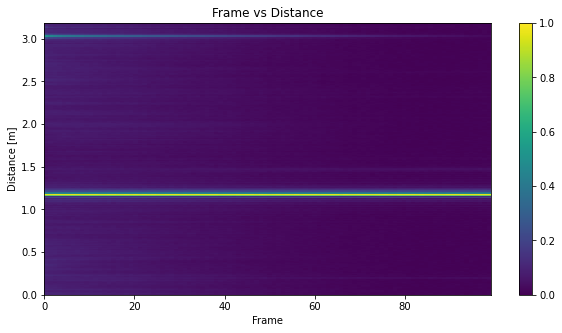

1.1715661680675384


In [9]:
# ground trugh of range profile
range_profile_ifft = my_vtrig.range_pipeline(case=current_case,scenario=current_scenario,cal_method=0,plot=True)
print(my_vtrig.dist_vec[np.argmax(range_profile_ifft[50,:])])

Freq Points: 150 
TxRxPairs Shape: (400, 2)
Nfft = 512
Number of Recorded Frames: 100

Current scenario: cf_x_angle_0

calArr Shape: (10, 400, 150)
recArr Shape: (100, 400, 150)

recArr Channels: (frame, Tx*Rx, freqs)

Current scenario: cf_x_angle_0

calArr Shape: (10, 400, 150)
recArr Shape: (100, 400, 150)

recArr Channels: (frame, Tx*Rx, freqs)

[0.52335698 0.54562978 0.59616104 0.64300748 0.46303744 0.54212449
 0.12189496 0.40990903 0.46995766 0.22016227 0.53968426 0.44206676
 0.5255999  0.23720584 0.23132967 0.7215994  1.         0.77136571
 0.45167557 0.40347102 0.58578521 0.56550286 0.31318549 0.56909348
 0.59901429 0.48833122 0.42092919 0.3084997  0.31166085 0.39505412
 0.4605735  0.62841096 0.20745702 0.68933892 0.32710673 0.19902662
 0.47456547 0.74366365 0.57226362 0.2394503  0.29352856 0.61243701
 0.63438195 0.4545145  0.01600951 0.24931587 0.78680328 0.17029133
 0.26609602 0.54948384 0.41557977 0.50284987 0.29504172 0.50572411
 0.02372272 0.66280415 0.66069831 0.65385618 0

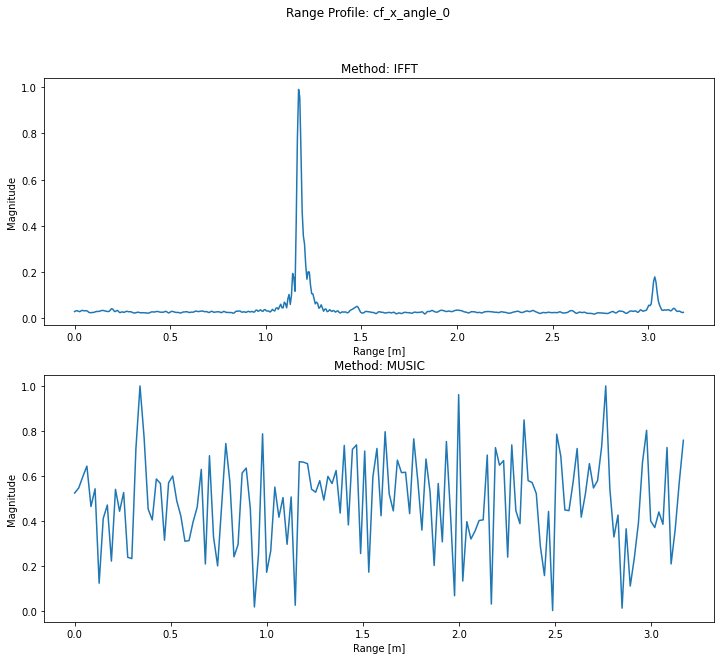

In [16]:
current_case = 'test01242023'
my_vtrig = isens_vtrigU(case=current_case)

for angle in ['0']:
    current_scenario = f'cf_x_angle_{angle}'
    calArr, recArr = my_vtrig.load_data(case=current_case, scenario=current_scenario)
    cur_proArr = my_vtrig.calibration(calArr,recArr,method=0)

    my_vtrig.Nfft = 150
    range_profile_ifft = my_vtrig.normalization(my_vtrig.range_pipeline(case=current_case,scenario=current_scenario,cal_method=0,plot=False))

    test_signal = cur_proArr[50,10,:]
    time_vec = np.linspace(0,Ts*(len(my_vtrig.freq)-1),num=len(my_vtrig.freq),dtype='complex')
    scanning_vectors = compute_tof_scanning_vector(my_vtrig.freq,time_vec)
    range_profile_music = compute_tof_music(test_signal=test_signal, scanning_vectors=scanning_vectors, signal_dimension=3,plot=False)

    fig, axs = plt.subplots(2,figsize=(12,10))
    fig.suptitle(f'Range Profile: {current_scenario}')
    axs[0].plot(my_vtrig.dist_vec,range_profile_ifft[50,:])
    axs[0].set_title('Method: IFFT')
    axs[0].set_xlabel('Range [m]')
    axs[0].set_ylabel('Magnitude')
    axs[1].plot(dist_vec,range_profile_music)
    axs[1].set_title('Method: MUSIC')
    axs[1].set_xlabel('Range [m]')
    axs[1].set_ylabel('Magnitude')


In [11]:
def R_l(l,cur_loc):
    """
    l: Index of TxRxPair
    cur_loc: Targeting Location

    Purpose: compute the average distance between the target and the l-th pair of transmitter and receiver
    """
    tx_idx = my_vtrig.TxRxPairs[l,0]-1
    rx_idx = my_vtrig.TxRxPairs[l,1]-1
    x_m, y_m = my_vtrig.ants_locations[tx_idx,:]
    x_n, y_n = my_vtrig.ants_locations[rx_idx,:]
    z_m, z_n = 0.0, 0.0
    x_t, y_t, z_t = cur_loc
    return (np.sqrt((x_m-x_t)**2 + (y_m-y_t)**2 + (z_m-z_t)**2)+np.sqrt((x_n-x_t)**2 + (y_n-y_t)**2 + (z_n-z_t)**2)) / 2

def S_t(S, l, Q, cur_loc):
    """
    S: Receieved Signal
    l: Index of TxRxPair
    Q: number of frequency points

    Purpose: Convert the receieved signal in to time domain with specified target location; for TDBP imaging method
    """

    cur_R = R_l(l, cur_loc)

    kq = 2*np.pi*my_vtrig.freq/c
    shift_element = np.exp(1j*2*kq*cur_R,dtype='complex')
    
    St = S[l,:]*shift_element
    St = np.sum(St) / Q

    return St

def reflection_coefficient(S, loc):
    print(f'current location: {loc}')
    MN = len(my_vtrig.TxRxPairs)
    corr_matrix = np.zeros((MN-1,MN-1),dtype='complex')
    Q = len(my_vtrig.freq)
    St = []
    for i in range(MN):
        St.append(S_t(S,i,Q,loc))
    St = np.array(St)
    corr_matrix = St[:-1].reshape(1,-1) * St[1:].reshape(-1,1)
    return np.abs(np.sum(corr_matrix))

In [12]:
import multiprocessing as mp

x_grid = np.arange(-3,3,0.5)
y_grid = np.arange(-3,3,0.5)
z_grid = np.arange(-3,3,0.5)

point_cloud = np.zeros((len(x_grid),len(y_grid),len(z_grid)))
pool = mp.Pool()
for i, x in enumerate(x_grid):
    for j, y in enumerate(y_grid):
        for k, z in enumerate(z_grid):
            output = pool.apply_async(reflection_coefficient,(proArr[50,:,:],np.array([x,y,z])))
            point_cloud[i,j,k] = output.get()
pool.close()


current location: [-3. -3. -3.]
current location: [-3.  -3.  -2.5]
current location: [-3. -3. -2.]
current location: [-3.  -3.  -1.5]
current location: [-3. -3. -1.]
current location: [-3.  -3.  -0.5]
current location: [-3. -3.  0.]
current location: [-3.  -3.   0.5]
current location: [-3. -3.  1.]
current location: [-3.  -3.   1.5]
current location: [-3. -3.  2.]
current location: [-3.  -3.   2.5]
current location: [-3.  -2.5 -3. ]
current location: [-3.  -2.5 -2.5]
current location: [-3.  -2.5 -2. ]
current location: [-3.  -2.5 -1.5]
current location: [-3.  -2.5 -1. ]
current location: [-3.  -2.5 -0.5]
current location: [-3.  -2.5  0. ]
current location: [-3.  -2.5  0.5]
current location: [-3.  -2.5  1. ]
current location: [-3.  -2.5  1.5]
current location: [-3.  -2.5  2. ]
current location: [-3.  -2.5  2.5]
current location: [-3. -2. -3.]
current location: [-3.  -2.  -2.5]
current location: [-3. -2. -2.]
current location: [-3.  -2.  -1.5]
current location: [-3. -2. -1.]
current loca

Process ForkPoolWorker-3:
Process ForkPoolWorker-8:
Process ForkPoolWorker-9:
Process ForkPoolWorker-7:
Process ForkPoolWorker-1:
Process ForkPoolWorker-2:
Process ForkPoolWorker-10:
Process ForkPoolWorker-6:
Process ForkPoolWorker-4:
Process ForkPoolWorker-5:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/anaconda3/envs/vtrigU/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/anaconda3/envs/vtrigU/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/anaconda3/envs/vtrigU/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/anaconda3/envs/vtrigU/lib

KeyboardInterrupt: 

  File "/opt/anaconda3/envs/vtrigU/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/opt/anaconda3/envs/vtrigU/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/opt/anaconda3/envs/vtrigU/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:


  File "/opt/anaconda3/envs/vtrigU/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/var/folders/j0/r66byps97n1bdgk1fk2zwtlh0000gn/T/ipykernel_13551/412638384.py", line 36, in reflection_coefficient
    print(f'current location: {loc}')
  File "/opt/anaconda3/envs/vtrigU/lib/python3.7/multiprocessing/queues.py", line 352, in get
    res = self._reader.recv_bytes()
  File "/opt/anaconda3/envs/vtrigU/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/opt/anaconda3/envs/vtrigU/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/opt/anaconda3/envs/vtrigU/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/opt/anaconda3/envs/vtrigU/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/opt/anaconda3/envs/vtrigU/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.

(array([0]), array([4]), array([0]))


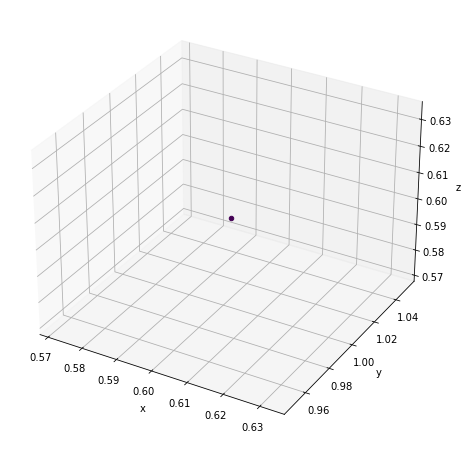

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
normalized_pc = my_vtrig.normalization(point_cloud)
print(np.where(normalized_pc>0.8))
z, x, y = normalized_pc[np.where(normalized_pc>0.5)]
ax.scatter(x, y, z, c=z, alpha=1)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

In [26]:
import numpy as np
import scipy.signal as sig
from numpy.linalg import eig

# Define radar parameters
fs = 80e3  # Sampling frequency
bw = 7e9  # Bandwidth
f_start = 62e9  # Start frequency
f_stop = f_start + bw  # Stop frequency
t_sweep = 10e-6  # Sweep time
tx_antennas = 20  # Number of transmitting antennas
rx_antennas = 20  # Number of receiving antennas
tx_spacing = 0.0022  # Transmitter spacing
rx_spacing = 0.0022  # Receiver spacing
c = 299792458  # Speed of light

# Define signal parameters
n_targets = 2  # Number of targets
target_ranges = [0.3, 0.6]  # Target ranges
target_amplitudes = [1, 0.5]  # Target amplitudes
tau = 10e-6  # Delay

# Generate chirp signal
t = np.arange(0, t_sweep, 1/fs)
tx_signal = sig.chirp(t, f_start, t_sweep, f_stop)

# Generate received signals
rx_signals = []
for i in range(rx_antennas):
    rx_signal = np.zeros(len(tx_signal))
    for j in range(tx_antennas):
        time_delay = 2 * target_ranges[0] / c
        rx_signal += target_amplitudes[0] * np.roll(tx_signal, int(time_delay*fs*j*tx_spacing*rx_spacing))
        time_delay = 2 * target_ranges[1] / c
        rx_signal += target_amplitudes[1] * np.roll(tx_signal, int(time_delay*fs*j*tx_spacing*rx_spacing))
    rx_signals.append(rx_signal)

# Combine received signals
rx_signal_combined = np.sum(rx_signals, axis=0)

# Define the steering vector
def steering_vector(n, d, f, theta):
    k = 2 * np.pi * f / c
    return np.exp(1j * k * d * np.sin(theta * np.pi / 180) * np.arange(n))

# Compute the steering matrix
n_fft = 1024
f = np.fft.rfftfreq(n_fft, d=1/fs)
S = np.zeros((rx_antennas, n_fft), dtype=np.complex)
for i in range(rx_antennas):
    for j in range(n_fft):
        S[i,j] = np.dot(steering_vector(tx_antennas, tx_spacing, f[j], np.arange(-90, 91)), np.fft.rfft(rx_signals[i], n=n_fft))
w, V = eig(np.dot(S, S.conj().T))
idx = np.argsort(w)[::-1]
Vn = V[:,idx[n_targets:]]
theta = np.arange(-90, 91)
tof = np.zeros_like(theta, dtype=np.float)
for i in range(len(theta)):
    tof[i] = np.angle(np.dot(Vn.conj().T, steering_vector(tx_antennas, tx_spacing, f, theta[i])))

# Calculate range
range_est = tof * c / 2

# Plot results
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(theta, np.abs(range_est))
ax.set_xlabel('Angle (degrees)')
ax.set_ylabel('Range (m)')
plt.show()


/opt/anaconda3/envs/vtrigU/lib/python3.7/site-packages/ipykernel_launcher.py:49: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


ValueError: operands could not be broadcast together with shapes (181,) (20,) 

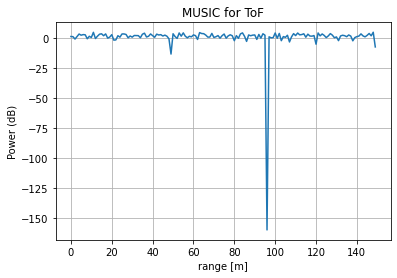

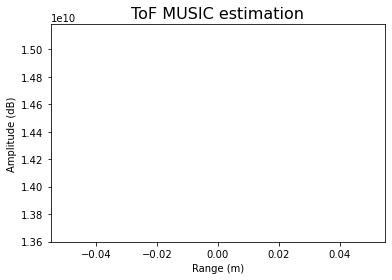

In [36]:
import numpy as np
import scipy.signal as sig
from numpy.linalg import eig

# Define radar parameters
fs = 80e3
bw = 7e9
f_start = 62e9
f_stop = 69e9
n_freq_steps = 150
t_sweep = 1/fs*n_freq_steps
tx_antennas = 20
rx_antennas = 20
tx_spacing = 0.5
rx_spacing = 0.5
c = 299792458

# Define signal parameters
n_targets = 2
target_ranges = [1.0, 1.5]
target_amplitudes = [1, 0.5]
tau = 10e-6

# Generate chirp signal
t = np.linspace(0, t_sweep, int(fs * t_sweep))
tx_signal = sig.chirp(t, f_start, t_sweep, f_stop)

# Generate received signals
rx_signals = []
for i in range(rx_antennas):
    rx_signal = np.zeros(len(tx_signal))
    for j in range(tx_antennas):
        for t_idx in range(n_targets):
            time_delay = 2 * target_ranges[t_idx] / c
            rx_signal += target_amplitudes[t_idx] * np.roll(tx_signal, int(time_delay*fs*j*tx_spacing*rx_spacing))
    rx_signals.append(rx_signal)

# Combine received signals
rx_signal_combined = np.sum(rx_signals, axis=0)

# Define the steering vector
def compute_tof_scanning_vector(freq, time_vec):
    n_freq = len(freq)
    n_time = len(time_vec)
    scanning_vectors = np.zeros((n_freq, n_time), dtype=complex)
    for i in range(n_freq):
        for j in range(n_time):
            scanning_vectors[i, j] = np.exp(-1j * 2 * np.pi * freq[i] * time_vec[j])
    return scanning_vectors

def compute_tof_music(test_signal, scanning_vectors, signal_dimension, plot=False):
    test_signal = test_signal.reshape(-1,1)

    # Compute the correlation matrix
    R = np.dot(test_signal, test_signal.conj().T)

    # Implement MUSIC for ToF
    tof = np.zeros(np.size(scanning_vectors, 1))
    M = np.size(R, 0)

    # Determine eigenvectors and eigenvalues
    sigmai, vi = eig(R)
    # Sorting    
    eig_array = []
    for i in range(M):
        eig_array.append([np.abs(sigmai[i]),vi[:,i]])
    eig_array = sorted(eig_array, key=lambda eig_array: eig_array[0], reverse=False)

    # Generate noise subspace matrix
    noise_dimension = M - signal_dimension    
    E = np.zeros((M,noise_dimension),dtype=complex)
    for i in range(noise_dimension):     
        E[:,i] = eig_array[i][1]     
        
    E = np.matrix(E)    
    theta_index=0
    for i in range(np.size(scanning_vectors, 1)):             
        S_theta_ = scanning_vectors[:, i]
        S_theta_  = np.matrix(S_theta_).getT() 
        tof[theta_index]=  1/np.abs(S_theta_.getH()*(E*E.getH())*S_theta_)
        theta_index += 1

    tof = np.divide(np.abs(tof),np.max(np.abs(tof))) # normalization 
    tof = 10*np.log10(tof)                
    time_index = np.argmax(tof)

    if plot:
        plt.figure()
        Ts = 1/len(my_vtrig.freq)/(my_vtrig.freq[1]-my_vtrig.freq[0]+1e-16) # Avoid nan checks
        time_vec = np.linspace(0,Ts*(len(my_vtrig.freq)-1),num=len(my_vtrig.freq))
        dist_vec = time_vec*(c/2)
        plt.plot(10*np.log10(np.abs(tof)+1e-16))
        plt.xlabel('range [m]')
        plt.ylabel('Power (dB)')
        plt.title('MUSIC for ToF')
        plt.grid()
        plt.show()

    return time_index


time_vec = np.linspace(0, t_sweep, n_freq_steps)

scanning_vectors = compute_tof_scanning_vector(np.linspace(f_start, f_stop, n_freq_steps), time_vec)

test_tof = compute_tof_music(test_signal=rx_signal_combined, scanning_vectors=scanning_vectors, signal_dimension=2, plot=True)

c = 299792458
range_est = np.multiply(test_tof, c / 2)

import matplotlib.pyplot as plt
dist_vec = np.linspace(0, (tx_antennas-1) * tx_spacing, tx_antennas)
plt.figure()
axes = plt.axes()
axes.plot(np.abs(range_est))
axes.set_title('ToF MUSIC estimation', fontsize=16)
axes.set_xlabel('Range (m)')
axes.set_ylabel('Amplitude (dB)')
plt.show()

In [10]:
def compute_tof_scanning_vector(freq, time_vec):
    n_freq = len(freq)
    n_time = len(time_vec)
    scanning_vectors = np.zeros((n_freq, n_time), dtype=complex)
    for i in range(n_freq):
        for j in range(n_time):
            scanning_vectors[i, j] = np.exp(-1j * 2 * np.pi * freq[i] * time_vec[j])
    return scanning_vectors


def compute_tof_music(test_signal, scanning_vectors, signal_dimension=3, plot=False):
    Ts = 1/len(my_vtrig.freq)/(my_vtrig.freq[1]-my_vtrig.freq[0]+1e-16) # Avoid nan checks
    time_vec = np.linspace(0,Ts*(len(my_vtrig.freq)-1),num=len(my_vtrig.freq))
    dist_vec = time_vec*(c/2)
    test_signal = test_signal.reshape(-1,1)

    # Compute the correlation matrix
    R = np.dot(test_signal, test_signal.conj().T)

    # Implement MUSIC for ToF
    tof = np.zeros(np.size(scanning_vectors, 1))
    M = np.size(R, 0)

    # Determine eigenvectors and eigenvalues
    sigmai, vi = eig(R)
    # Sorting    
    eig_array = []
    for i in range(M):
        eig_array.append([np.abs(sigmai[i]),vi[:,i]])
    eig_array = sorted(eig_array, key=lambda eig_array: eig_array[0], reverse=False)

    # Generate noise subspace matrix
    noise_dimension = M - signal_dimension    
    E = np.zeros((M,noise_dimension),dtype=complex)
    for i in range(noise_dimension):     
        E[:,i] = eig_array[i][1]     
        
    E = np.matrix(E)    
    theta_index=0
    for i in range(np.size(scanning_vectors, 1)):             
        S_theta_ = scanning_vectors[:, i]
        S_theta_  = np.matrix(S_theta_).getT() 
        tof[theta_index]=  1/np.abs(S_theta_.getH()*(E*E.getH())*S_theta_)
        theta_index += 1

    tof = np.divide(np.abs(tof),np.max(np.abs(tof))) # normalization 
    tof = 10*np.log10(tof)                
    time_index = np.argmax(tof)
    print(dist_vec[time_index])

    if plot:
        plt.figure()
        plt.plot(dist_vec,np.abs(10*np.log10(np.abs(tof)+1e-16)))
        plt.xlabel('range [m]')
        plt.ylabel('Power (dB)')
        plt.title('MUSIC for ToF')
        plt.grid()
        plt.show()
    # print(tof)
    return tof

# Extract the data of the first TxRx pair in the first frame
test_signal = proArr[0,0,:]
time_vec = np.linspace(0,Ts*(len(my_vtrig.freq)-1),num=len(my_vtrig.freq),dtype='complex')
scanning_vectors = compute_tof_scanning_vector(my_vtrig.freq,time_vec)
test_tof = compute_tof_music(test_signal=test_signal, scanning_vectors=scanning_vectors, signal_dimension=10,plot=True)

NameError: name 'proArr' is not defined

In [46]:
# import library
import numpy as np
from isens_vtrigU import isens_vtrigU
import matplotlib.pyplot as plt
import os
from scipy.signal import find_peaks
from math import log, ceil
from sklearn.cluster import DBSCAN
from scipy.spatial import distance



bound = 2.5
Nfft = 512
ntarget = 6
y_offset_shift = 220
x_offset_shift = -90
x_ratio = 20/30
y_ratio = 20/25
threshold = 0.971
doppler_thres = 0.8

def filter_and_cluster(matrix, threshold=0.0, n=np.inf):
    indices = np.argwhere(matrix > threshold)

    clustering = DBSCAN(eps=1, min_samples=1).fit(indices)
    labels = clustering.labels_
    unique_labels = np.unique(labels)

    cluster_sizes = [(label, sum(labels == label)) for label in unique_labels if label != -1]
    cluster_sizes.sort(key=lambda x: x[1], reverse=True)

    selected_indices = []
    for i in range(min(n, len(cluster_sizes))):
        label = cluster_sizes[i][0]
        cluster_indices = indices[labels == label]
        centroid = cluster_indices.mean(axis=0)
        selected_indices.append(cluster_indices[distance.cdist([centroid], cluster_indices).argmin()])

    return np.array(selected_indices)




def normalization(data):
    return (data-np.min(data))/(np.max(data)-np.min(data))

def find_n_largest(matrix, n):
    flat = matrix.flatten()
    indices = np.argpartition(flat, -n)[-n:]  # get the indices of the top n values
    indices = indices[np.argsort(-flat[indices])]  # sort the indices
    indices_2d = np.unravel_index(indices, matrix.shape)  # convert the indices to 2D
    return list(zip(indices_2d[0], indices_2d[1]))

def gen_range_doppler(proArr, range_Nfft, doppler_Nfft, dist_vec):
    tof = np.fft.ifft(proArr,n=Nfft,axis=2)                      # Do IFFT across frequency steps to get the range bins
    tof[:,:,np.where(dist_vec>bound)] = np.min(tof)       # Eliminate noise that is beyond the range
    # tof = tof.reshape(nframe,400,-1)#[chosen_frame,:,:,:]      # Reshape the range profile to Tx x Rx and extract a frame
    print(tof.shape)
    range_doppler = tof.copy()
    range_doppler = np.linalg.norm(range_doppler, axis=1)
    print(range_doppler.shape)
    
    # Doppler FFT
    range_doppler = np.fft.fft(np.real(range_doppler),n=doppler_Nfft,axis=0)
    range_doppler = np.abs(range_doppler).T # (range, doppler)

    d=(2*60+2.8)/500
    # d = 1/fs
    doppler_freq = np.fft.fftfreq(doppler_Nfft,d)
    doppler_freq = doppler_freq[doppler_freq>=0]
    freq_low = np.where(doppler_freq>=0.3)[0][0]
    freq_high = np.where(doppler_freq<=2.0)[0][-1]
    range_low = np.where(dist_vec>=0.3)[0][0]
    range_high = np.where(dist_vec<=3.0)[0][-1]

    # Eliminate the high DC offset
    # range_low, range_high, freq_low, freq_high = 50, 400, 100, 300
    range_range = np.r_[0:range_low, range_high:range_doppler.shape[0]]
    doppler_range = np.r_[0:freq_low, freq_high:range_doppler.shape[1]]
    range_doppler[range_range,:] = np.min(range_doppler)
    range_doppler[:, doppler_range] = np.min(range_doppler)
    range_doppler_norm = np.linalg.norm(range_doppler,axis=1)

    range_doppler = normalization(range_doppler)
    rd_peaks_indices = filter_and_cluster(matrix=range_doppler[range_low:range_high,freq_low:freq_high], threshold=0.5, n=6)
    range_bins = rd_peaks_indices[0]

    return range_bins

def main():
    current_case = "test05012023"
    current_scenario = "human_walk_radar"
    current_scenario_path = os.path.join("./data", current_case, current_scenario)

    my_vtrig = isens_vtrigU(case=current_case)
    

    # processed_data_dir = "frames_point_cloud_NFFT=512"
    # point_cloud_path = os.path.join("./data",current_case,current_scenario,processed_data_dir)
    calArr = np.load(os.path.join(current_scenario_path,"calibration.npy"))
    recArr = np.load(os.path.join(current_scenario_path,"recording.npy"))
    proArr = recArr - np.mean(calArr,axis=0)
    Nfft = 2**(ceil(log(proArr.shape[2],2))+1)
    doppler_Nfft =  2**(ceil(log(10,2))+1)

    nframe = recArr.shape[0]
    chosen_frame = 50

    my_vtrig.dist_vec = my_vtrig.compute_dist_vec(Nfft=Nfft)

    # for chosen_frame in range(nframe):
    # Compute the Range Profile and Find the Target Range Bin (For one target)
    range_profile = my_vtrig.range_pipeline(current_case,current_scenario, plot=False, Nfft=Nfft)[chosen_frame,:]
    range_profile[np.where(my_vtrig.dist_vec>bound)] = np.mean(range_profile)
    range_peaks, _ = find_peaks(range_profile)
    # Sort the peaks by their amplitudes in descending order and select the first 6 peaks
    sorted_peak_indices = np.argsort(range_profile[range_peaks])[::-1][:ntarget]
    top_range_peaks = range_peaks[sorted_peak_indices]

    tof = np.fft.ifft(proArr,n=Nfft,axis=2)                      # Do IFFT across frequency steps to get the range bins
    tof[:,:,np.where(my_vtrig.dist_vec>bound)] = np.min(tof)       # Eliminate noise that is beyond the range
    # tof = tof.reshape(nframe,400,-1)#[chosen_frame,:,:,:]      # Reshape the range profile to Tx x Rx and extract a frame
    # print(tof.shape)
    range_doppler = tof.copy()
    range_doppler = np.linalg.norm(range_doppler, axis=1)
    # print(range_doppler.shape)
    
    for i in range(range_doppler.shape[0]-9):
        # Doppler FFT
        range_doppler_frame = np.fft.fft(np.real(range_doppler[i:i+10,:]),n=doppler_Nfft,axis=0)
        range_doppler_frame = np.abs(range_doppler_frame).T # (range, doppler)
        # np.save(f'./doppler_data/range_doppler_{current_scenario}_{i}.npy',range_doppler)

        d=(2*60+2.8)/500
        # d = 1/fs
        doppler_freq = np.fft.fftfreq(doppler_Nfft,d)
        doppler_freq = doppler_freq[doppler_freq>=0]
        freq_low = np.where(doppler_freq>=0.3)[0][0]
        freq_high = np.where(doppler_freq<=2.0)[0][-1]
        range_low = np.where(my_vtrig.dist_vec>=0.3)[0][0]
        range_high = np.where(my_vtrig.dist_vec<=2.5)[0][-1]
        # print(range_doppler_frame.shape)

        # Eliminate the high DC offset
        # range_low, range_high, freq_low, freq_high = 50, 400, 100, 300
        range_range = np.r_[0:range_low, range_high:range_doppler_frame.shape[0]]
        doppler_range = np.r_[0:freq_low, freq_high:range_doppler_frame.shape[1]]
        range_doppler_frame[range_range,:] = np.min(range_doppler_frame)
        range_doppler_frame[:, doppler_range] = np.min(range_doppler_frame)
        range_doppler_norm = np.linalg.norm(range_doppler_frame,axis=1)

        range_doppler_frame = normalization(range_doppler_frame)
        # rd_peaks_indices = filter_and_cluster(matrix=range_doppler[range_low:range_high,freq_low:freq_high], threshold=0.5, n=6)
        # print(rd_peaks_indices)
        
        extent=[doppler_freq[freq_low],doppler_freq[freq_high],my_vtrig.dist_vec[range_low],my_vtrig.dist_vec[range_high]]

        # print(range_doppler_frame.shape)
        range_doppler_norm = normalization(range_doppler_norm)
        # rd_peaks_indices = find_n_largest(range_doppler, 6)

        plt.figure(figsize=(10,10))
        plt.imshow(range_doppler_frame[range_low:range_high,freq_low:freq_high],origin="lower",aspect="auto",extent=extent)
        # plt.scatter(doppler_freq[freq_low:freq_high][rd_peaks_indices[:, 1]], my_vtrig.dist_vec[range_low:range_high][rd_peaks_indices[:, 0]], color='r', marker='x')
        plt.colorbar()
        plt.xlabel('Doppler Frequency [Hz]')
        plt.ylabel('Range [m]')
        plt.title(f'Setup: {current_scenario}, frame: {i}')
        plt.savefig(f'./tmp_img/range_doppler_{current_scenario}_plot_frame.jpg')
        plt.close()

   
    # plt.figure(figsize=(8,6))
    # plt.plot(my_vtrig.dist_vec, range_doppler_norm)
    # plt.xlabel('Range [m]')
    # plt.ylabel('Doppler Magnitude')
    # plt.grid()
    # plt.show()

   
    
if __name__ == '__main__':
    main()

(150,)
0.005622855509379451
(512,)
Top 6 range bin indices: [38, 2, 35, 54]
Top 6 range bins: [0.23680593 0.01246347 0.21811072 0.33651369] [m]


/opt/anaconda3/envs/vtrigU/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/vtrigU/lib/python3.7/site-packages/scipy/signal/_peak_finding.py:261: ComplexWarning: Casting complex values to real discards the imaginary part
  value = np.asarray(value, order='C', dtype=np.float64)


x_peaks indices [ 0  0  0  0  0  0  1  1  1  2  2  2  2  2  2  3  3  3  3  3  3  3  3  4
  4  4  5  5  5  5  5  6  6  6  6  6  6  6  7  7  7  7  7  7  7  8  8  8
  8  8  9  9  9  9  9  9  9 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11
 11 12 12 12 12 12 12 12 13 13 13 13 13 14 14 14 14 14 15 15 15 15 15 15
 15 16 16 16 16 17 17 18 18 18 18 18 18 18 19 19 20 22 22 22 22 22 22 22
 23 23 23 23 23 23 24 24 24 24 24 25 25 25 25 25 26 26 26 26 26 26 27 27
 27 27 28 28 28 28 29 29 29 29 29 29 29 29 29 29 29 29 29 30 30 30 30 30
 30 30 30 30 30 30 30 30 30 30 30 30 30 30 31 31 31 31 31 31 31 31 31 31
 31 32 32 32 33 33 33 34 34 34 34 34 34 34 34 34 34 35 35 35 35 35 35 35
 35 35 35 35 35 35 35 35 35 35 36 36 36 36 36 36 36 36 36 37 37 38 39 39
 39 39 39 40 40 40 41 41 41 42 42 42 42 42 42 42 43 43 43 43 43 43 43 44
 44 46 46 46 47 49 49 49 50 50 50 50 50 51 51 52 52 52 53 53 53 54 54 54
 54 54 55 55 55 56 56 56 56 57 57 57 57 58 58 58 58 58 58 58 59 59 59 59
 59 59 59 59 59 59 59 59 59 60 60 6

/opt/anaconda3/envs/vtrigU/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/vtrigU/lib/python3.7/site-packages/scipy/signal/_peak_finding.py:261: ComplexWarning: Casting complex values to real discards the imaginary part
  value = np.asarray(value, order='C', dtype=np.float64)


x_peaks indices [ 0  0  0 ... 63 63 63]
y_peaks indices [13 14 18 ... 54 55 56]
z_peaks indices [35 35 35 ... 35 35 35]
AoD [-52.50002188 -52.50002188 -52.50002188 ...  52.50002188  52.50002188
  52.50002188] [deg]
AoA [-36.45320197 -34.48275862 -26.60098522 ...  44.33497537  46.30541872
  48.27586207] [deg]
Range [0.21811072 0.21811072 0.21811072 ... 0.21811072 0.21811072 0.21811072] [m]
AoD, AoA, Range:  -0.8333336805557015 2.9556650246305463 0.2181107227785311
AoD, AoA, Range:  -7.500003125001305 0.9852216748768488 0.01869520480958838
AoD, AoA, Range:  12.500005208335505 14.778325123152712 0.33651368657259084
AoD, AoA, Range:  30.833346180560913 -34.48275862068966 0.01869520480958838
AoD, AoA, Range:  -40.83335034722931 14.778325123152712 0.33651368657259084
AoD, AoA, Range:  -0.8333336805557015 -48.27586206896552 0.33651368657259084
1.5118911266326904 [s]
(150,)
0.004333595423085457
(512,)
Top 6 range bin indices: [40, 7, 35, 54, 1, 35]
Top 6 range bins: [0.2492694  0.04362214 0.21

/opt/anaconda3/envs/vtrigU/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/vtrigU/lib/python3.7/site-packages/scipy/signal/_peak_finding.py:261: ComplexWarning: Casting complex values to real discards the imaginary part
  value = np.asarray(value, order='C', dtype=np.float64)


x_peaks indices [ 0  0  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3
  3  3  3  3  3  4  4  4  4  4  4  4  4  4  4  5  5  5  5  5  5  5  6  6
  6  7  7  7  7  8  8  8  8  9  9  9  9  9  9 10 10 10 10 10 10 10 10 11
 11 11 11 11 11 12 12 12 12 12 13 13 13 14 14 14 15 15 15 15 19 21 22 22
 23 23 23 23 24 24 24 24 24 24 24 24 25 25 25 25 25 25 25 25 25 25 25 26
 26 26 26 26 26 26 26 26 27 27 27 27 27 27 28 28 28 28 28 29 29 29 30 31
 31 32 32 32 32 32 32 32 32 32 32 32 32 32 33 33 33 33 33 33 33 33 33 33
 33 33 33 33 33 34 34 34 34 34 34 34 34 34 35 35 35 35 35 35 36 36 36 36
 36 36 36 36 37 37 37 37 37 37 37 37 37 38 38 38 38 38 39 39 39 39 39 40
 40 40 40 40 41 41 41 41 41 42 42 42 42 43 43 44 44 44 45 45 45 45 45 46
 46 46 46 47 48 48 48 48 49 49 49 49 49 50 50 50 50 50 50 51 51 51 51 51
 52 52 52 52 52 53 53 53 53 54 54 54 55 55 57 63]
y_peaks indices [37 38 12 35 36 37  7  8 11 34 35 38 38 39 42 43 44  7 11 16 34 36 37 37
 38 40 41 42 43  3  6  7 15 24 36 39 40 41

/opt/anaconda3/envs/vtrigU/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/vtrigU/lib/python3.7/site-packages/scipy/signal/_peak_finding.py:261: ComplexWarning: Casting complex values to real discards the imaginary part
  value = np.asarray(value, order='C', dtype=np.float64)


x_peaks indices [16 16]
y_peaks indices [38 39]
z_peaks indices [33 33]
AoD [-25.8333441 -25.8333441] [deg]
AoA [12.80788177 14.77832512] [deg]
Range [0.20564725 0.20564725] [m]
AoD, AoA, Range:  -25.833344097226707 12.807881773399014 0.20564725290547217
2.9550201892852783 [s]
(150,)
0.0032922541719665093
(512,)
Top 6 range bin indices: [43, 234, 99, 36, 1]
Top 6 range bins: [0.2679646  1.45822598 0.61694176 0.22434246 0.00623173] [m]


/opt/anaconda3/envs/vtrigU/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/vtrigU/lib/python3.7/site-packages/scipy/signal/_peak_finding.py:261: ComplexWarning: Casting complex values to real discards the imaginary part
  value = np.asarray(value, order='C', dtype=np.float64)


x_peaks indices [27 27 28 28 30 31 31 32]
y_peaks indices [37 38 35 36 40 38 39 37]
z_peaks indices [36 36 36 36 36 36 36 36]
AoD [-7.50000313 -7.50000313 -5.83333576 -5.83333576 -2.50000104 -0.83333368
 -0.83333368  0.83333368] [deg]
AoA [10.83743842 12.80788177  6.89655172  8.86699507 16.74876847 12.80788177
 14.77832512 10.83743842] [deg]
Range [0.22434246 0.22434246 0.22434246 0.22434246 0.22434246 0.22434246
 0.22434246 0.22434246] [m]
AoD, AoA, Range:  -0.8333336805557015 12.807881773399014 0.22434245771506056
3.636165142059326 [s]
(150,)
0.0033412613595498303
(512,)
Top 6 range bin indices: [39, 36, 87, 99, 236, 35]
Top 6 range bins: [0.24303766 0.22434246 0.54216094 0.61694176 1.47068945 0.21811072] [m]


/opt/anaconda3/envs/vtrigU/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/vtrigU/lib/python3.7/site-packages/scipy/signal/_peak_finding.py:261: ComplexWarning: Casting complex values to real discards the imaginary part
  value = np.asarray(value, order='C', dtype=np.float64)


x_peaks indices [28 28 29 29 30 61 62 62]
y_peaks indices [38 39 36 37 35 38 36 37]
z_peaks indices [39 39 39 39 39 39 39 39]
AoD [-5.83333576 -5.83333576 -4.1666684  -4.1666684  -2.50000104 49.16668715
 50.83335451 50.83335451] [deg]
AoA [12.80788177 14.77832512  8.86699507 10.83743842  6.89655172 12.80788177
  8.86699507 10.83743842] [deg]
Range [0.24303766 0.24303766 0.24303766 0.24303766 0.24303766 0.24303766
 0.24303766 0.24303766] [m]
AoD, AoA, Range:  -4.166668402778499 10.837438423645327 0.24303766252464895
AoD, AoA, Range:  50.83335451389772 10.837438423645327 0.24303766252464895
4.315058946609497 [s]
(150,)
0.003291010398493594
(512,)
Top 6 range bin indices: [39, 87, 35, 98, 236, 1]
Top 6 range bins: [0.24303766 0.54216094 0.21811072 0.61071002 1.47068945 0.00623173] [m]


/opt/anaconda3/envs/vtrigU/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/vtrigU/lib/python3.7/site-packages/scipy/signal/_peak_finding.py:261: ComplexWarning: Casting complex values to real discards the imaginary part
  value = np.asarray(value, order='C', dtype=np.float64)


x_peaks indices [ 0  0  0 ... 63 63 63]
y_peaks indices [ 0  0  0 ... 63 63 63]
z_peaks indices [  1  35  39 ...  87  98 236]
AoD [-52.50002188 -52.50002188 -52.50002188 ...  52.50002188  52.50002188
  52.50002188] [deg]
AoA [-62.06896552 -62.06896552 -62.06896552 ...  62.06896552  62.06896552
  62.06896552] [deg]
Range [0.00623173 0.21811072 0.24303766 ... 0.54216094 0.61071002 1.47068945] [m]
AoD, AoA, Range:  -0.8333336805557015 -0.9852216748768488 0.2181107227785311
AoD, AoA, Range:  -0.8333336805557015 -0.9852216748768488 0.00623173493652946
AoD, AoA, Range:  -0.8333336805557015 -0.9852216748768488 0.542160939478063
AoD, AoA, Range:  -0.8333336805557015 -0.9852216748768488 0.610710023779887
AoD, AoA, Range:  -0.8333336805557015 -0.9852216748768488 1.4706894450209524
6.055578231811523 [s]
(150,)
0.0031825493609774773
(512,)
Top 6 range bin indices: [42, 36, 98, 236, 1, 36]
Top 6 range bins: [0.26173287 0.22434246 0.61071002 1.47068945 0.00623173 0.22434246] [m]


/opt/anaconda3/envs/vtrigU/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/vtrigU/lib/python3.7/site-packages/scipy/signal/_peak_finding.py:261: ComplexWarning: Casting complex values to real discards the imaginary part
  value = np.asarray(value, order='C', dtype=np.float64)


x_peaks indices [ 0  0  0 ... 63 63 63]
y_peaks indices [ 0  0  0 ... 63 63 63]
z_peaks indices [  1  36  42 ...  42  98 236]
AoD [-52.50002188 -52.50002188 -52.50002188 ...  52.50002188  52.50002188
  52.50002188] [deg]
AoA [-62.06896552 -62.06896552 -62.06896552 ...  62.06896552  62.06896552
  62.06896552] [deg]
Range [0.00623173 0.22434246 0.26173287 ... 0.26173287 0.61071002 1.47068945] [m]
AoD, AoA, Range:  -0.8333336805557015 -0.9852216748768488 0.22434245771506056
AoD, AoA, Range:  -0.8333336805557015 -0.9852216748768488 0.00623173493652946
AoD, AoA, Range:  -0.8333336805557015 -0.9852216748768488 0.610710023779887
AoD, AoA, Range:  -0.8333336805557015 -0.9852216748768488 1.4706894450209524
7.6407530307769775 [s]
(150,)
0.0031870799560389513
(512,)
Top 6 range bin indices: [45, 8, 80, 36, 1, 35, 236]
Top 6 range bins: [0.28042807 0.04985388 0.49853879 0.22434246 0.00623173 0.21811072
 1.47068945] [m]


/opt/anaconda3/envs/vtrigU/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/vtrigU/lib/python3.7/site-packages/scipy/signal/_peak_finding.py:261: ComplexWarning: Casting complex values to real discards the imaginary part
  value = np.asarray(value, order='C', dtype=np.float64)


x_peaks indices [ 0  0  0 ... 63 63 63]
y_peaks indices [ 0  0  0 ... 63 63 63]
z_peaks indices [  1   8  35 ...  45  80 236]
AoD [-52.50002188 -52.50002188 -52.50002188 ...  52.50002188  52.50002188
  52.50002188] [deg]
AoA [-62.06896552 -62.06896552 -62.06896552 ...  62.06896552  62.06896552
  62.06896552] [deg]
Range [0.00623173 0.04985388 0.21811072 ... 0.28042807 0.49853879 1.47068945] [m]
AoD, AoA, Range:  -0.8333336805557015 -0.9852216748768488 0.22434245771506056
AoD, AoA, Range:  -0.8333336805557015 -0.9852216748768488 0.00623173493652946
AoD, AoA, Range:  -0.8333336805557015 -0.9852216748768488 0.4985387949223568
AoD, AoA, Range:  -0.8333336805557015 -0.9852216748768488 1.4706894450209524
9.609817266464233 [s]
(150,)
0.003788925545529868
(512,)
Top 6 range bin indices: [45, 7, 36, 35, 1, 35, 65]
Top 6 range bins: [0.28042807 0.04362214 0.22434246 0.21811072 0.00623173 0.21811072
 0.40506277] [m]


/opt/anaconda3/envs/vtrigU/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/vtrigU/lib/python3.7/site-packages/scipy/signal/_peak_finding.py:261: ComplexWarning: Casting complex values to real discards the imaginary part
  value = np.asarray(value, order='C', dtype=np.float64)


x_peaks indices [ 0  0  0 ... 63 63 63]
y_peaks indices [ 0  0  0 ... 63 63 63]
z_peaks indices [ 1  7 35 ... 36 45 65]
AoD [-52.50002188 -52.50002188 -52.50002188 ...  52.50002188  52.50002188
  52.50002188] [deg]
AoA [-62.06896552 -62.06896552 -62.06896552 ...  62.06896552  62.06896552
  62.06896552] [deg]
Range [0.00623173 0.04362214 0.21811072 ... 0.22434246 0.28042807 0.40506277] [m]
AoD, AoA, Range:  -0.8333336805557015 -0.9852216748768488 0.22434245771506056
AoD, AoA, Range:  -0.8333336805557015 -0.9852216748768488 0.00623173493652946
AoD, AoA, Range:  -0.8333336805557015 -0.9852216748768488 0.4050627708744149
11.418773174285889 [s]
(150,)
0.004860356150594911
(512,)
Top 6 range bin indices: [36, 2, 35, 45, 54]
Top 6 range bins: [0.22434246 0.01246347 0.21811072 0.28042807 0.33651369] [m]


/opt/anaconda3/envs/vtrigU/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/vtrigU/lib/python3.7/site-packages/scipy/signal/_peak_finding.py:261: ComplexWarning: Casting complex values to real discards the imaginary part
  value = np.asarray(value, order='C', dtype=np.float64)


x_peaks indices [ 0  0  0 ... 63 63 63]
y_peaks indices [ 0  0  0 ... 63 63 63]
z_peaks indices [ 2 35 36 ... 36 45 54]
AoD [-52.50002188 -52.50002188 -52.50002188 ...  52.50002188  52.50002188
  52.50002188] [deg]
AoA [-62.06896552 -62.06896552 -62.06896552 ...  62.06896552  62.06896552
  62.06896552] [deg]
Range [0.01246347 0.21811072 0.22434246 ... 0.22434246 0.28042807 0.33651369] [m]
AoD, AoA, Range:  -0.8333336805557015 -0.9852216748768488 0.28042807214382565
AoD, AoA, Range:  -0.8333336805557015 -0.9852216748768488 0.01246346987305892
12.99460506439209 [s]
(150,)
0.005457547203128469
(512,)
Top 6 range bin indices: [36, 1, 54, 35]
Top 6 range bins: [0.22434246 0.00623173 0.33651369 0.21811072] [m]


/opt/anaconda3/envs/vtrigU/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/vtrigU/lib/python3.7/site-packages/scipy/signal/_peak_finding.py:261: ComplexWarning: Casting complex values to real discards the imaginary part
  value = np.asarray(value, order='C', dtype=np.float64)


x_peaks indices [ 0  0  0 ... 63 63 63]
y_peaks indices [ 0  0  0 ... 63 63 63]
z_peaks indices [ 1 35 36 ... 35 36 54]
AoD [-52.50002188 -52.50002188 -52.50002188 ...  52.50002188  52.50002188
  52.50002188] [deg]
AoA [-62.06896552 -62.06896552 -62.06896552 ...  62.06896552  62.06896552
  62.06896552] [deg]
Range [0.00623173 0.21811072 0.22434246 ... 0.21811072 0.22434246 0.33651369] [m]
AoD, AoA, Range:  -0.8333336805557015 -0.9852216748768488 0.2181107227785311
AoD, AoA, Range:  -0.8333336805557015 -0.9852216748768488 0.00623173493652946
AoD, AoA, Range:  -0.8333336805557015 -0.9852216748768488 0.33651368657259084
14.310405254364014 [s]
(150,)
0.005252130242337069
(512,)
Top 6 range bin indices: [36, 1, 54]
Top 6 range bins: [0.22434246 0.00623173 0.33651369] [m]


/opt/anaconda3/envs/vtrigU/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/vtrigU/lib/python3.7/site-packages/scipy/signal/_peak_finding.py:261: ComplexWarning: Casting complex values to real discards the imaginary part
  value = np.asarray(value, order='C', dtype=np.float64)


x_peaks indices [ 0  0  0 ... 63 63 63]
y_peaks indices [ 0  0  0 ... 63 63 63]
z_peaks indices [ 1 36 54 ...  1 36 54]
AoD [-52.50002188 -52.50002188 -52.50002188 ...  52.50002188  52.50002188
  52.50002188] [deg]
AoA [-62.06896552 -62.06896552 -62.06896552 ...  62.06896552  62.06896552
  62.06896552] [deg]
Range [0.00623173 0.22434246 0.33651369 ... 0.00623173 0.22434246 0.33651369] [m]
AoD, AoA, Range:  -0.8333336805557015 -0.9852216748768488 0.00623173493652946
AoD, AoA, Range:  -0.8333336805557015 -0.9852216748768488 0.22434245771506056
AoD, AoA, Range:  -0.8333336805557015 -0.9852216748768488 0.33651368657259084
15.499491214752197 [s]
(150,)
0.004263679295238071
(512,)
Top 6 range bin indices: [38, 55, 2, 35]
Top 6 range bins: [0.23680593 0.34274542 0.01246347 0.21811072] [m]


/opt/anaconda3/envs/vtrigU/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/vtrigU/lib/python3.7/site-packages/scipy/signal/_peak_finding.py:261: ComplexWarning: Casting complex values to real discards the imaginary part
  value = np.asarray(value, order='C', dtype=np.float64)


x_peaks indices [ 0  0  0 ... 63 63 63]
y_peaks indices [ 0  0  0 ... 63 63 63]
z_peaks indices [ 2 35 38 ... 35 38 55]
AoD [-52.50002188 -52.50002188 -52.50002188 ...  52.50002188  52.50002188
  52.50002188] [deg]
AoA [-62.06896552 -62.06896552 -62.06896552 ...  62.06896552  62.06896552
  62.06896552] [deg]
Range [0.01246347 0.21811072 0.23680593 ... 0.21811072 0.23680593 0.34274542] [m]


KeyboardInterrupt: 

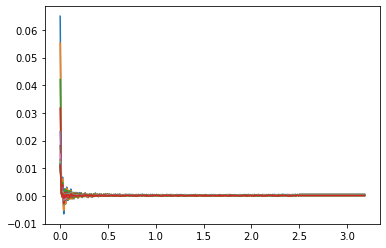

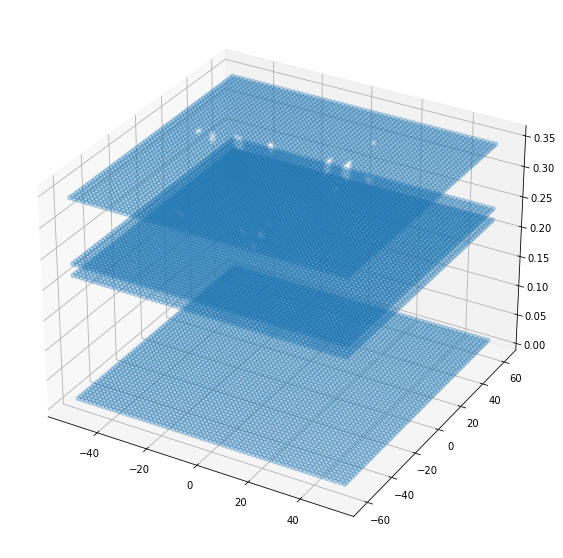

In [85]:
# Load Library
from math import ceil, log
from time import time

import numpy as np
from isens_vtrigU import isens_vtrigU
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D, proj3d
from scipy.constants import c
from scipy.io import savemat
from scipy.ndimage import uniform_filter
from scipy.signal import find_peaks
from scipy.spatial import distance
from sklearn.cluster import DBSCAN

def cfar(matrix, num_train_cells, threshold_scale_factor):
    """
    Apply the Cell Averaging CFAR algorithm to a 2D or 3D matrix.

    Parameters:
    - matrix: The 2D or 3D matrix to apply CFAR to.
    - num_train_cells: The number of training cells (in each direction from the cell under test).
    - threshold_scale_factor: The factor to scale the average noise level by to get the threshold.

    Returns:
    A binary matrix of the same shape as the input where cells with a value of 1 exceed the CFAR threshold.
    """
    # Calculate the average noise level in the neighbourhood of each cell
    avg_noise_level = uniform_filter(matrix, size=2*num_train_cells+1, mode='constant', cval=0)

    # Multiply the average noise level by the threshold scale factor to get the threshold
    threshold = avg_noise_level * threshold_scale_factor

    # Create a binary matrix where cells with a value of 1 exceed the CFAR threshold
    cfar_matrix = (matrix > threshold).astype(int)

    # Find the indices of cells that exceed the threshold
    cfar_indices = np.argwhere(cfar_matrix == 1)

    return cfar_indices

def normalization(data):
    return (data-np.min(data))/(np.max(data)-np.min(data))

def range_doppler_peaks(proArr, range_Nfft, doppler_Nfft, frame, dist_vec, plot=True):
    tof = np.fft.ifft(proArr,n=range_Nfft,axis=2)                      # Do IFFT across frequency steps to get the range bins
    tof[:,:,np.where(my_vtrig.dist_vec>bound)] = np.min(tof)       # Eliminate noise that is beyond the range
    # tof = tof.reshape(nframe,400,-1)#[chosen_frame,:,:,:]      # Reshape the range profile to Tx x Rx and extract a frame
    # print(tof.shape)
    range_doppler = tof.copy()
    range_doppler = np.linalg.norm(range_doppler, axis=1)
    # print(range_doppler.shape)
    
    # Doppler FFT
    range_doppler_frame = np.fft.fft(np.real(range_doppler[frame:frame+10,:]),n=doppler_Nfft,axis=0)
    range_doppler_frame = np.abs(range_doppler_frame).T # (range, doppler)
    # np.save(f'./doppler_data/range_doppler_{current_scenario}_{i}.npy',range_doppler)

    d=(2*60+2.8)/500
    # d = 1/fs
    doppler_freq = np.fft.fftfreq(doppler_Nfft,d)
    doppler_freq = doppler_freq[doppler_freq>=0]
    freq_low = np.where(doppler_freq>=0.3)[0][0]
    freq_high = np.where(doppler_freq<=2.0)[0][-1]
    range_low = np.where(my_vtrig.dist_vec>=0.5)[0][0]
    range_high = np.where(my_vtrig.dist_vec<=2.0)[0][-1]
    # print(range_doppler_frame.shape)

    # Eliminate the high DC offset
    # range_low, range_high, freq_low, freq_high = 50, 400, 100, 300
    range_range = np.r_[0:range_low, range_high:range_doppler_frame.shape[0]]
    doppler_range = np.r_[0:freq_low, freq_high:range_doppler_frame.shape[1]]
    range_doppler_frame[range_range,:] = np.min(range_doppler_frame)
    range_doppler_frame[:, doppler_range] = np.min(range_doppler_frame)
    print(np.max(range_doppler_frame))
    # return

    range_doppler_frame = normalization(range_doppler_frame)
    # print(np.max(range_doppler_frame))
    # plt.imshow(range_doppler_frame, aspect='auto', origin='lower')
    

    rd_peaks_indices = filter_and_cluster(matrix=range_doppler_frame[range_low:range_high,freq_low:freq_high], threshold=0.5)
    range_bins = rd_peaks_indices[:,0]
    if plot:
        extent=[doppler_freq[freq_low],doppler_freq[freq_high],my_vtrig.dist_vec[range_low],my_vtrig.dist_vec[range_high]]
        # rd_peaks_indices = find_n_largest(range_doppler, 6)

        plt.figure(figsize=(10,10))
        plt.imshow(range_doppler_frame[range_low:range_high,freq_low:freq_high],origin="lower",aspect="auto",extent=extent)
        # plt.scatter(doppler_freq[freq_low:freq_high][rd_peaks_indices[:, 1]], my_vtrig.dist_vec[range_low:range_high][rd_peaks_indices[:, 0]], color='r', marker='x')
        plt.colorbar()
        plt.xlabel('Doppler Frequency [Hz]')
        plt.ylabel('Range [m]')
        plt.title(f'Setup: {current_scenario}, frame: {i}')
        plt.scatter(doppler_freq[freq_low:freq_high][rd_peaks_indices[:, 1]], my_vtrig.dist_vec[range_low:range_high][rd_peaks_indices[:, 0]], color='r', marker='x')
        plt.show()

    
    return list(range_bins), range_doppler[range_low:range_high,freq_low:freq_high], range_low, range_high

def find_closest_index(arr, value):
    diff = np.abs(arr - value)
    return np.argmin(diff)

def filter_and_cluster(matrix, threshold=0.0, n=np.inf, eps=1, min_samples=3):
    indices = np.argwhere(matrix > threshold)

    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(indices)
    labels = clustering.labels_
    unique_labels = np.unique(labels)

    cluster_sizes = [(label, sum(labels == label)) for label in unique_labels if label != -1]
    cluster_sizes.sort(key=lambda x: x[1], reverse=True)

    selected_indices = []
    for i in range(min(n, len(cluster_sizes))):
        label = cluster_sizes[i][0]
        cluster_indices = indices[labels == label]
        centroid = cluster_indices.mean(axis=0)
        selected_indices.append(cluster_indices[distance.cdist([centroid], cluster_indices).argmin()])

    return np.array(selected_indices)

start = time()
# Load Data
# current_case = 'test01242023'
# current_scenario = 'cf_x_angle_+20'
# current_case = 'test01242023'
# current_scenario = 'cf_x_angle_+20'
current_case = 'test05012023'
current_scenario = '2cf_moving_opposite'
rd_peaks_channels = True
cfar_channels = False
Nfft = 0
angle_Nfft = [64, 64] # [AoD, AoA]
range_Nfft = 512
my_vtrig = isens_vtrigU(case=current_case, range_Nfft=range_Nfft, angle_Nfft=angle_Nfft)
calArr, recArr = my_vtrig.load_data(case=current_case, scenario=current_scenario)
# threshold = 0.93 # corner reflectors
threshold = 0.995


# Parameter Setup
nframe = recArr.shape[0]

ntarget = 6             # number of 
bound = 2.5
if angle_Nfft[0] == 64:
    x_offset_shift = -11
    x_ratio = 20/(34.2857)
elif angle_Nfft[0] == 512: #(Nfft=512)
    x_offset_shift = -90
    x_ratio = 20/30
else: #(Nfft=512)
    x_offset_shift = 0
    x_ratio = 1

if angle_Nfft[1] == 64:
    y_offset_shift = 27
    y_ratio = 20/29
elif angle_Nfft[1] == 512: #(Nfft=512)
    y_offset_shift = 220 
    y_ratio = 20/25
else: #(Nfft=512)
    y_offset_shift = 0 
    y_ratio = 1


my_vtrig.dist_vec = my_vtrig.compute_dist_vec(Nfft=range_Nfft)

x_array = (my_vtrig.AoD_vec-90)*x_ratio
y_array = (my_vtrig.AoA_vec-90)*y_ratio
z_array = my_vtrig.dist_vec


# x_offset_shift = find_closest_index(x_array,x_offset_shift)
# print(x_offset_shift)

# Background Substraction
proArr = my_vtrig.calibration(calArr,recArr,method=0)
doppler_Nfft =  2**(ceil(log(10,2))+1)

for chosen_frame in range(nframe-9):
    # Compute the Range Profile and Find the Target Range Bin (For one target)
    range_profile = np.linalg.norm(proArr[chosen_frame,:,:],axis=0)
    print(range_profile.shape)
    range_profile = np.fft.ifft(range_profile,n=512)
    range_profile[np.where(my_vtrig.dist_vec>bound)] = np.mean(range_profile)
    # range_profile[np.where(my_vtrig.dist_vec<0.3)] = np.mean(range_profile)
    if rd_peaks_channels:
        rd_peaks_idx, range_doppler, range_low, range_high = range_doppler_peaks(proArr=proArr, range_Nfft=range_Nfft, doppler_Nfft=doppler_Nfft, frame=chosen_frame, dist_vec=my_vtrig.dist_vec, plot=False)

    if cfar_channels:
        num_train_cells = 5
        threshold_scale_factor = 1.2
        cfar_idx = cfar(range_doppler, num_train_cells, threshold_scale_factor)
        cfar_idx = list(set([int(np.where(my_vtrig.dist_vec == val)[0].flatten()) for val in my_vtrig.dist_vec[range_low:range_high][cfar_idx[:,0]]]))
    plt.plot(my_vtrig.dist_vec,range_profile)


    range_peaks, _ = find_peaks(range_profile)
    print(range_profile.shape)
    # Sort the peaks by their amplitudes in descending order and select the first 6 peaks
    sorted_peak_indices = np.argsort(range_profile[range_peaks])[::-1][:ntarget]
    top_range_peaks = range_peaks[sorted_peak_indices]

    # Channels to search for peaks (replace these with your desired channels)
    if rd_peaks_channels:
        if cfar_channels:
            channels_to_search = cfar_idx
        else:
            channels_to_search = rd_peaks_idx
    else:
        channels_to_search = top_range_peaks

    # Print the indices and angles of the top 6 peaks
    print(f"Top {ntarget} range bin indices:", channels_to_search)
    print(f"Top {ntarget} range bins:", my_vtrig.dist_vec[channels_to_search], '[m]')
    # plt.figure(figsize=(20,10 ))
    # plt.plot(my_vtrig.dist_vec,range_profile)
    # plt.scatter(my_vtrig.dist_vec[top_range_peaks],range_profile[top_range_peaks])
    # plt.show()
    # Generate the 3D map
    # Arrays to change the axis values (replace these with your arrays)


    Nfft = 150
    tof = np.fft.ifft(proArr,n=range_Nfft,axis=2)                      # Do IFFT across frequency steps to get the range bins
    tof[:,:,np.where(my_vtrig.dist_vec>bound)] = np.min(tof)       # Eliminate noise that is beyond the range
    tof = tof.reshape(nframe,20,20,-1)[chosen_frame,:,:,:]      # Reshape the range profile to Tx x Rx and extract a frame
    Nfft = 20
    tof = np.fft.fft(tof,n=angle_Nfft[1],axis=1)
    tof = np.fft.fft(tof,n=angle_Nfft[0],axis=0)
    tof = my_vtrig.normalization(tof)
    tof = np.roll(tof,shift=y_offset_shift,axis=1)
    tof = np.roll(tof,shift=x_offset_shift,axis=0)
    tof = np.abs(tof)
    # new shape: (AoD, AoA, Range) = (x, y, z)
    # Example 3D matrix (replace this with your matrix)
    matrix = tof

    
    # print(top_range_peaks)

    # Create a masked copy of the matrix
    masked_matrix = matrix.copy()
    masked_matrix[:, :, [ch for ch in range(matrix.shape[2]) if ch not in channels_to_search]] = np.min(matrix)

    # Find the indices of the top 6 largest values
    flat_indices = np.argsort(masked_matrix.flatten())[::-1][:ntarget]
    indices_3d = np.unravel_index(flat_indices, matrix.shape)
    # Extract x, y, and z coordinates of the top 6 peaks
    x_peaks, y_peaks, z_peaks = indices_3d

    # Create a 3D scatter plot for the original matrix
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')

    # Get x, y, z indices for the entire matrix
    normalized_matrix = my_vtrig.normalization(masked_matrix)

    # Apply a threshold
    mask = normalized_matrix > threshold

    # Get x, y, z indices for the entire matrix
    x, y, z = np.indices(matrix.shape)

    # Add the entire matrix as blue points with changed axis values
    ax.scatter(x_array[x[mask]], y_array[y[mask]], z_array[z[mask]], alpha=0.3, label='All points',)
    print('x_peaks indices', x[mask])
    print('y_peaks indices', y[mask])
    print('z_peaks indices', z[mask])
    print('AoD', x_array[x[mask]], '[deg]')
    print('AoA', y_array[y[mask]],'[deg]')
    print('Range', z_array[z[mask]], '[m]')
    peak_indices = filter_and_cluster(normalized_matrix, threshold, n=6 ,eps=10, min_samples=1)
    # print(peak_indices)
    if len(peak_indices) != 0:
        for i in range(len(peak_indices)):
            print('AoD, AoA, Range: ',x_array[peak_indices[i,0]],y_array[peak_indices[i,1]],z_array[peak_indices[i,2]])
            ax.scatter(x_array[peak_indices[i,0]],y_array[peak_indices[i,1]],z_array[peak_indices[i,2]],marker='x', color='r')


    # Set axis labels
    ax.set_xlabel('X (AoD [deg])')
    ax.set_ylabel('Y (AoA [deg])')
    ax.set_zlabel('Z (Range [m])')
    # Set plot title
    plt.title(f"3D Point Cloud: {current_scenario}, frame: {chosen_frame}")
    # Set the axis limits to match the ranges of x_array, y_array, and z_array
    ax.set_xlim(x_array.min(), x_array.max())
    ax.set_ylim(y_array.min(), y_array.max())
    ax.set_zlim(z_array.min(), z_array.max())
    # Add legend
    ax.legend()
    plt.savefig(f'./tmp_img/point_cloud_{current_scenario}_plot_frame.jpg')
    plt.close()
    end = time()
    print(end-start, '[s]')
    
# Show the plot
